In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn import metrics
from category_encoders import TargetEncoder

In [3]:
log_shots = pd.read_csv('shot_logs.csv')

In [4]:
def convert_game_clock_to_seconds(clock_str):
    if isinstance(clock_str, str):
        parts = clock_str.split(':')
        if len(parts) == 2:
            minutes = int(parts[0])
            seconds = int(parts[1])
            return minutes * 60 + seconds
    return np.nan

log_shots['GAME_CLOCK_SECONDS'] = log_shots['GAME_CLOCK'].apply(convert_game_clock_to_seconds)
log_shots[['GAME_CLOCK', 'GAME_CLOCK_SECONDS']].head()
log_shots.drop(columns=['GAME_CLOCK'], inplace=True)
log_shots = log_shots.dropna(how = 'any', axis = 0)

In [5]:
log_shots.loc[log_shots['LOCATION'] == 'H', 'LOCATION'] = 1
log_shots.loc[log_shots['LOCATION'] == 'A', 'LOCATION'] = 0
log_shots['LOCATION'] = log_shots['LOCATION'].astype('int32')

log_shots.loc[log_shots['SHOT_RESULT'] == 'made', 'SHOT_RESULT'] = 1
log_shots.loc[log_shots['SHOT_RESULT'] == 'missed', 'SHOT_RESULT'] = 0
log_shots['SHOT_RESULT'] = log_shots['SHOT_RESULT'].astype('int32')

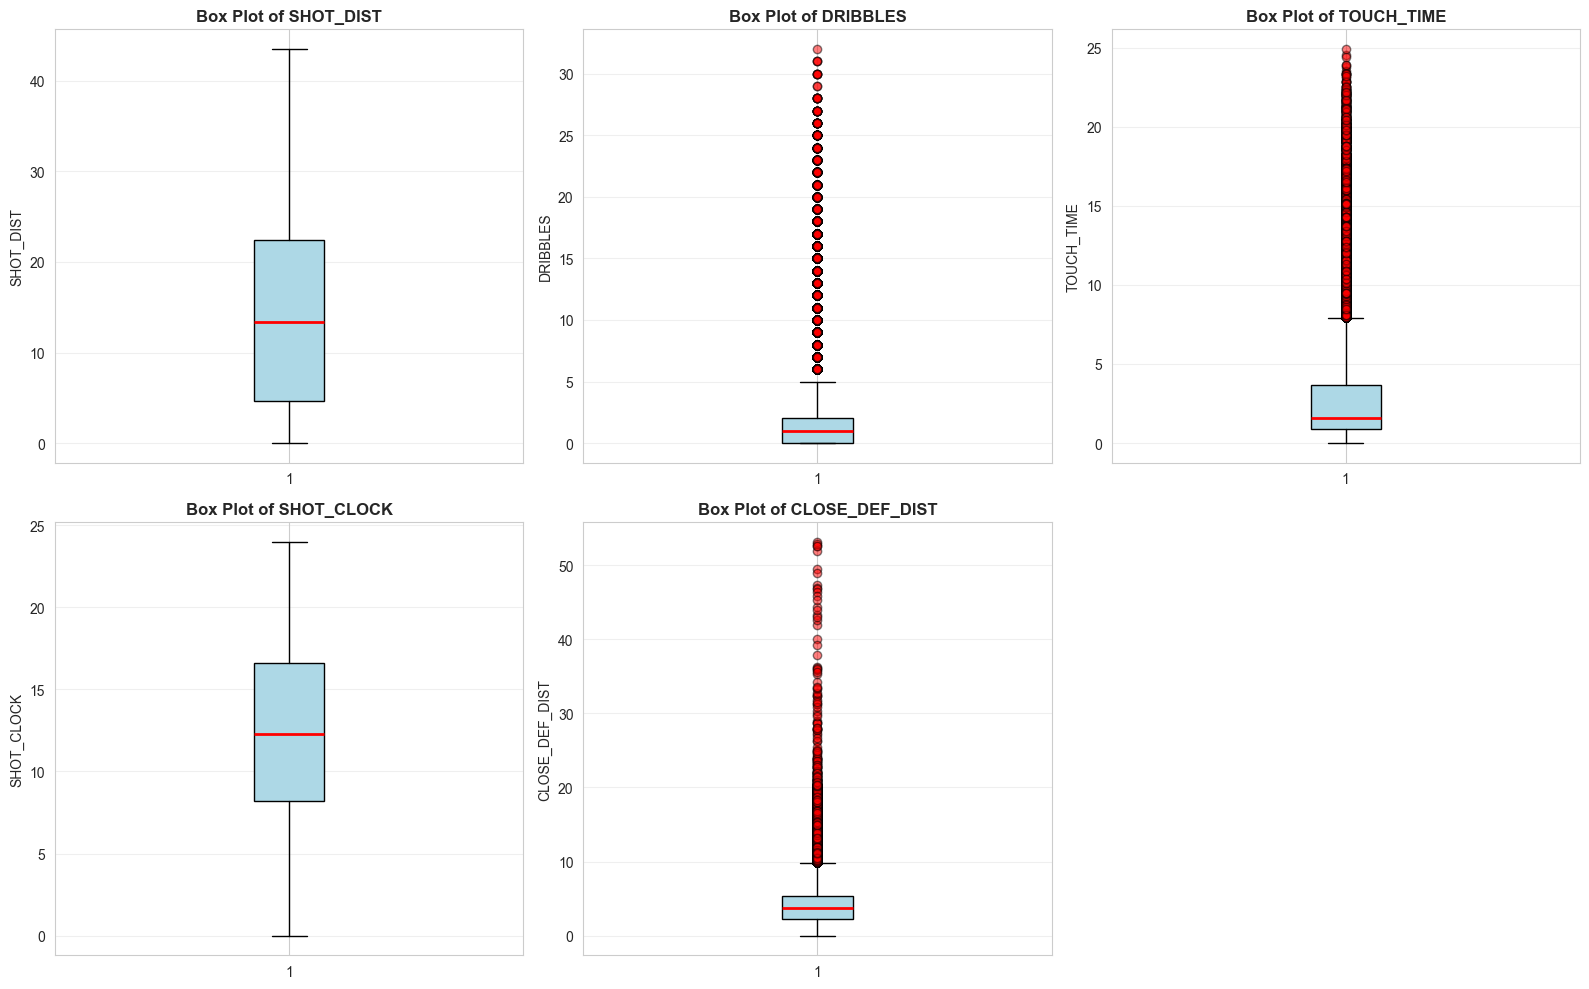

OUTLIER ANALYSIS

SHOT_DIST:
  Q1: 4.70, Q3: 22.40, IQR: 17.70
  Lower Bound: -21.85, Upper Bound: 48.95
  Number of Outliers: 0 (0.00%)
  Outlier Range: [nan, nan]

DRIBBLES:
  Q1: 0.00, Q3: 2.00, IQR: 2.00
  Lower Bound: -3.00, Upper Bound: 5.00
  Number of Outliers: 14032 (11.48%)
  Outlier Range: [6.00, 32.00]

TOUCH_TIME:
  Q1: 0.90, Q3: 3.70, IQR: 2.80
  Lower Bound: -3.30, Upper Bound: 7.90
  Number of Outliers: 7582 (6.20%)
  Outlier Range: [8.00, 24.90]

SHOT_CLOCK:
  Q1: 8.20, Q3: 16.60, IQR: 8.40
  Lower Bound: -4.40, Upper Bound: 29.20
  Number of Outliers: 0 (0.00%)
  Outlier Range: [nan, nan]

CLOSE_DEF_DIST:
  Q1: 2.30, Q3: 5.30, IQR: 3.00
  Lower Bound: -2.20, Upper Bound: 9.80
  Number of Outliers: 4339 (3.55%)
  Outlier Range: [9.90, 53.20]


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better-looking plots
sns.set_style("whitegrid")

# Features to analyze
features = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Create a box plot for each feature
for idx, feature in enumerate(features):
    axes[idx].boxplot(log_shots[feature], vert=True, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='black'),
                      medianprops=dict(color='red', linewidth=2),
                      whiskerprops=dict(color='black'),
                      capprops=dict(color='black'),
                      flierprops=dict(marker='o', markerfacecolor='red', markersize=6, alpha=0.5))
    axes[idx].set_title(f'Box Plot of {feature}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

# Print outlier information
print("="*70)
print("OUTLIER ANALYSIS")
print("="*70)
for feature in features:
    Q1 = log_shots[feature].quantile(0.25)
    Q3 = log_shots[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = log_shots[(log_shots[feature] < lower_bound) | (log_shots[feature] > upper_bound)]
    
    print(f"\n{feature}:")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
    print(f"  Number of Outliers: {len(outliers)} ({len(outliers)/len(log_shots)*100:.2f}%)")
    print(f"  Outlier Range: [{outliers[feature].min():.2f}, {outliers[feature].max():.2f}]")

In [7]:
# ============================================================================
# DROP NEGATIVE VALUES FROM TOUCH_TIME
# ============================================================================

print("="*70)
print("CLEANING TOUCH_TIME - REMOVING NEGATIVE VALUES")
print("="*70)

print(f"\nBefore cleaning:")
print(f"  Total rows: {len(log_shots)}")
print(f"  Negative TOUCH_TIME values: {(log_shots['TOUCH_TIME'] < 0).sum()}")
print(f"  Min TOUCH_TIME: {log_shots['TOUCH_TIME'].min()}")
print(f"  Max TOUCH_TIME: {log_shots['TOUCH_TIME'].max()}")

# Drop rows with negative TOUCH_TIME values
log_shots = log_shots[log_shots['TOUCH_TIME'] >= 0]

print(f"\nAfter cleaning:")
print(f"  Total rows: {len(log_shots)}")
print(f"  Negative TOUCH_TIME values: {(log_shots['TOUCH_TIME'] < 0).sum()}")
print(f"  Min TOUCH_TIME: {log_shots['TOUCH_TIME'].min()}")
print(f"  Max TOUCH_TIME: {log_shots['TOUCH_TIME'].max()}")

print("\n✓ Negative TOUCH_TIME values removed successfully!")

CLEANING TOUCH_TIME - REMOVING NEGATIVE VALUES

Before cleaning:
  Total rows: 122502
  Negative TOUCH_TIME values: 299
  Min TOUCH_TIME: -100.5
  Max TOUCH_TIME: 24.9

After cleaning:
  Total rows: 122203
  Negative TOUCH_TIME values: 0
  Min TOUCH_TIME: 0.0
  Max TOUCH_TIME: 24.9

✓ Negative TOUCH_TIME values removed successfully!



NORMALITY TESTS FOR FEATURES

SHOT_DIST

📊 SHAPIRO-WILK TEST:
   Test Statistic: 0.898977
   P-value: 2.212381e-49
   ✗ NON-NORMAL distribution (p < 0.05)

📊 KOLMOGOROV-SMIRNOV TEST:
   Test Statistic: 0.128948
   P-value: 0.000000e+00
   ✗ NON-NORMAL distribution (p < 0.05)

📊 ANDERSON-DARLING TEST:
   Test Statistic: 4626.078220
   Critical Values: [0.576 0.656 0.787 0.918 1.092]
   Significance Levels: [15.  10.   5.   2.5  1. ]%
   ✗ NON-NORMAL distribution (at 5% level)

📊 DESCRIPTIVE STATISTICS:
   Mean: 13.4491
   Median: 13.4000
   Std Dev: 8.7761
   Skewness: 0.0522
      → Fairly Symmetric ✓
   Kurtosis: -1.5506
      → Normal-like tails ✓

DRIBBLES

📊 SHAPIRO-WILK TEST:
   Test Statistic: 0.641758
   P-value: 4.171705e-73
   ✗ NON-NORMAL distribution (p < 0.05)

📊 KOLMOGOROV-SMIRNOV TEST:
   Test Statistic: 0.279577
   P-value: 0.000000e+00
   ✗ NON-NORMAL distribution (p < 0.05)

📊 ANDERSON-DARLING TEST:
   Test Statistic: 14813.822433
   Critical Values: [0.576 0.656 0.78

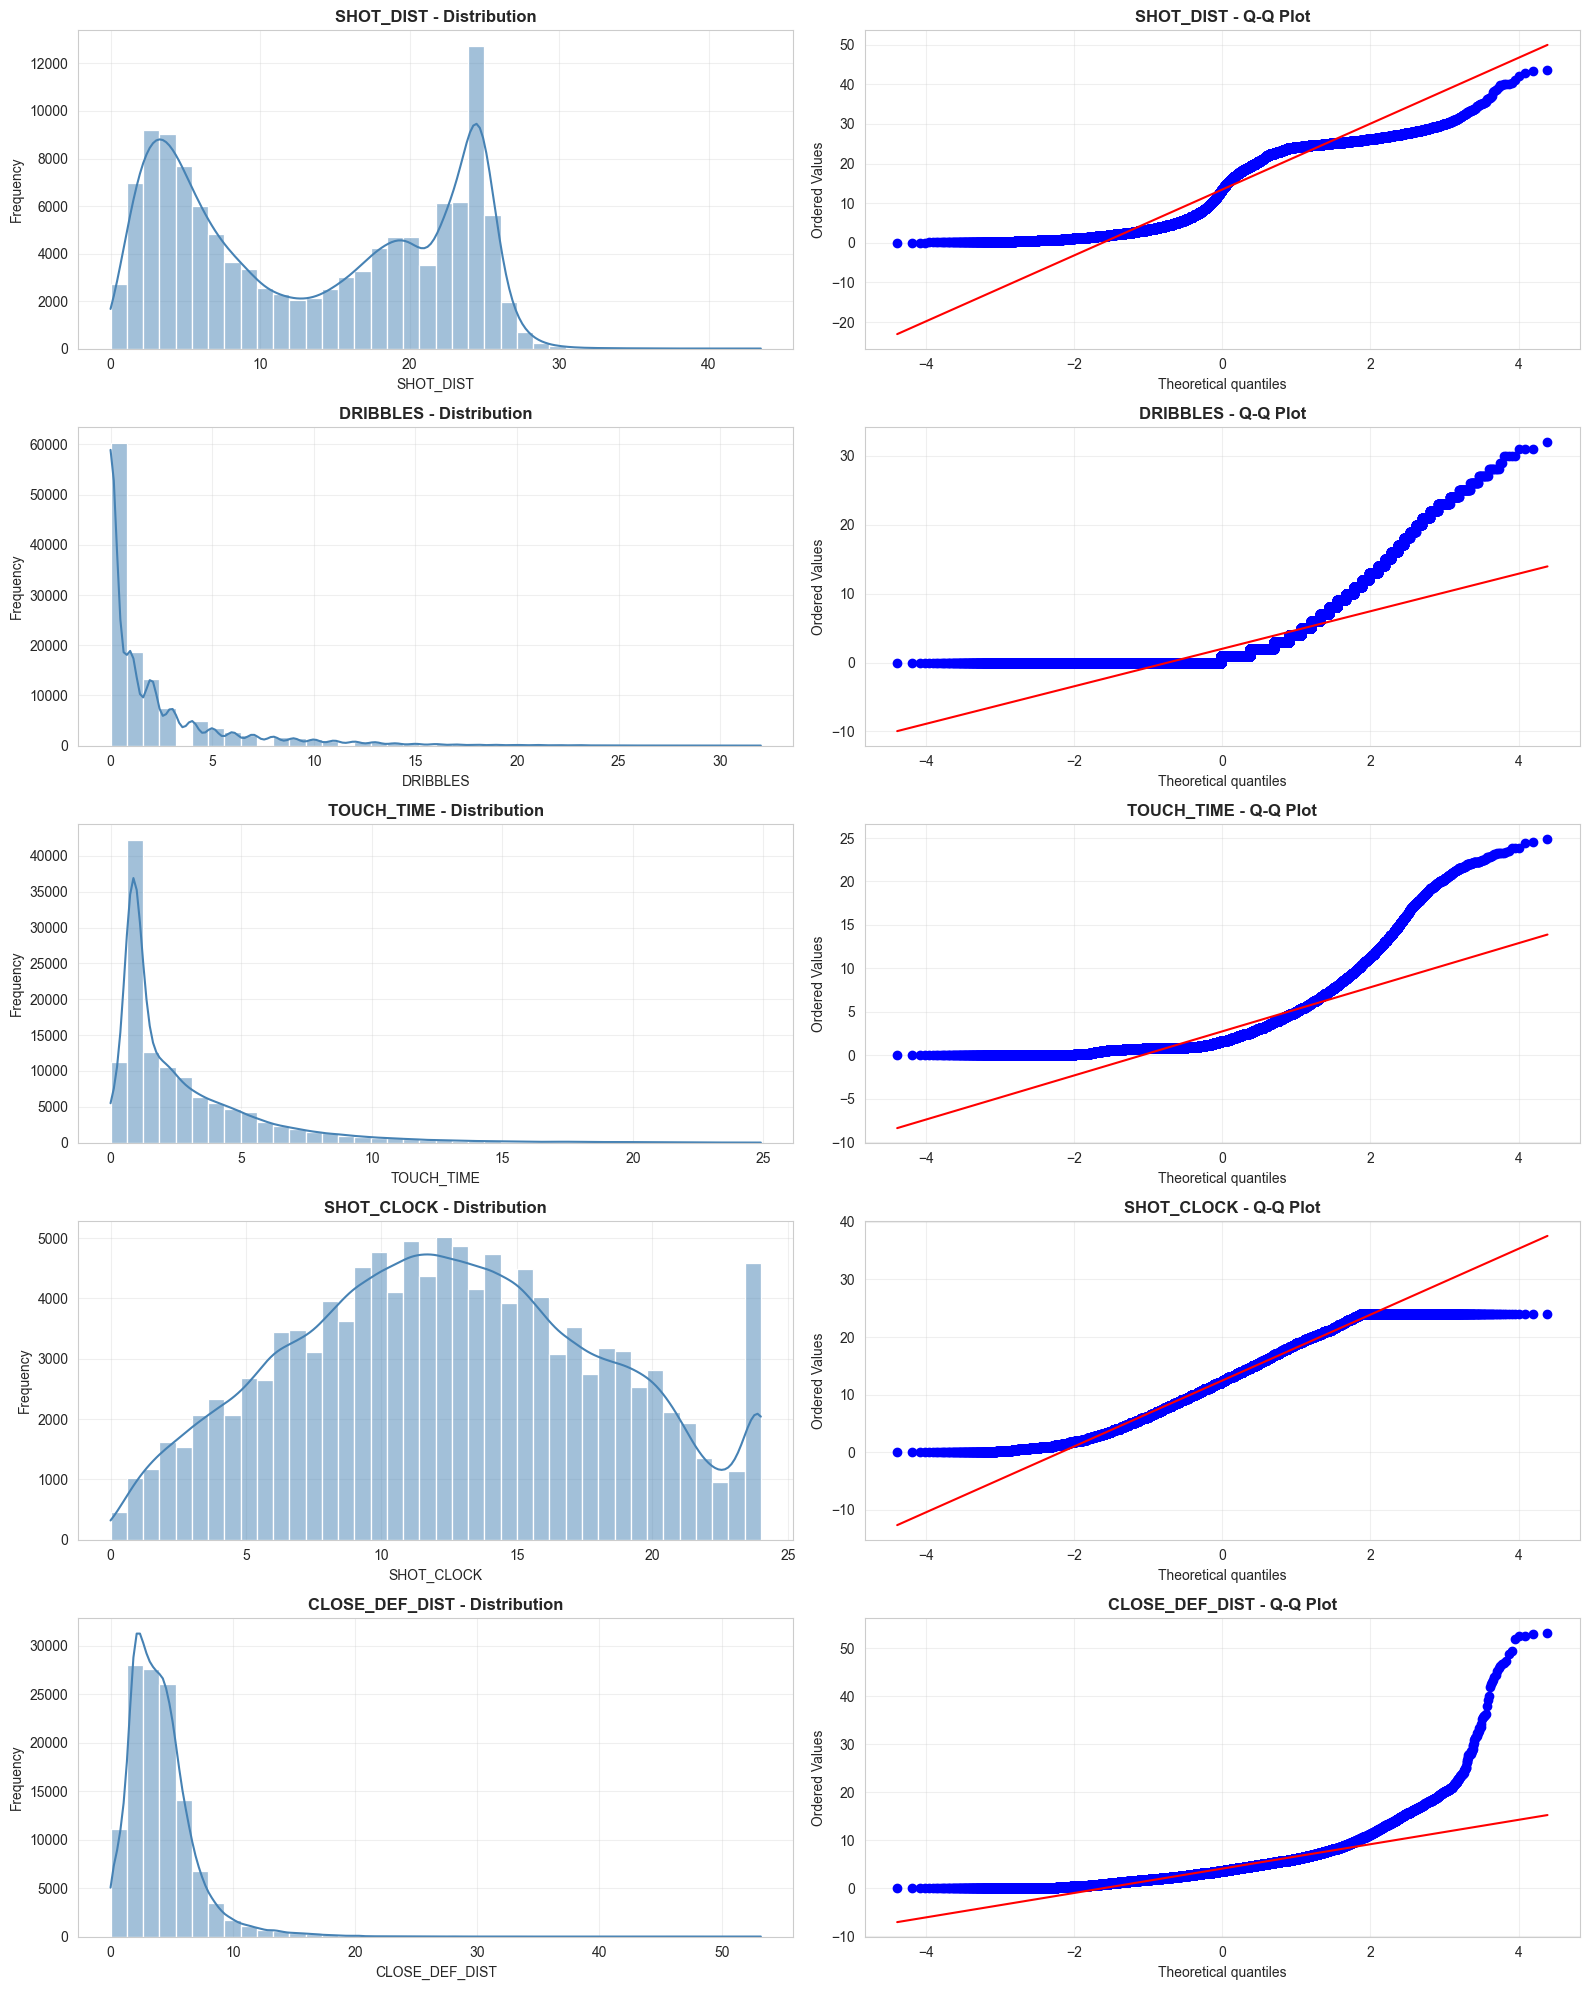


NORMALITY SUMMARY

Feature              Shapiro-Wilk p-value      Normal?        
------------------------------------------------------------
SHOT_DIST            2.212381e-49              ✗ NO           
DRIBBLES             4.171705e-73              ✗ NO           
TOUCH_TIME           7.032260e-66              ✗ NO           
SHOT_CLOCK           1.550016e-21              ✗ NO           
CLOSE_DEF_DIST       1.194830e-59              ✗ NO           



In [9]:

# ============================================================================
# CHECK NORMALITY OF FEATURES
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("NORMALITY TESTS FOR FEATURES")
print("="*70)

# Features to test
features = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create figure for Q-Q plots and histograms
fig, axes = plt.subplots(len(features), 2, figsize=(16, 4*len(features)))

normality_results = {}

for idx, feature in enumerate(features):
    print(f"\n{'='*70}")
    print(f"{feature}")
    print(f"{'='*70}")
    
    # Get data
    data = log_shots[feature].dropna()
    
    # 1. Shapiro-Wilk Test
    if len(data) > 5000:
        sample_data = data.sample(n=5000, random_state=42)
    else:
        sample_data = data
    
    stat, p_value = stats.shapiro(sample_data)
    normality_results[feature] = {'stat': stat, 'p_value': p_value}
    
    print(f"\n📊 SHAPIRO-WILK TEST:")
    print(f"   Test Statistic: {stat:.6f}")
    print(f"   P-value: {p_value:.6e}")
    if p_value > 0.05:
        print(f"   ✓ NORMAL distribution (p > 0.05)")
    else:
        print(f"   ✗ NON-NORMAL distribution (p < 0.05)")
    
    # 2. Kolmogorov-Smirnov Test (normalized data)
    normalized_data = (data - data.mean()) / data.std()
    ks_stat, ks_p = stats.kstest(normalized_data, 'norm')
    print(f"\n📊 KOLMOGOROV-SMIRNOV TEST:")
    print(f"   Test Statistic: {ks_stat:.6f}")
    print(f"   P-value: {ks_p:.6e}")
    if ks_p > 0.05:
        print(f"   ✓ NORMAL distribution (p > 0.05)")
    else:
        print(f"   ✗ NON-NORMAL distribution (p < 0.05)")
    
    # 3. Anderson-Darling Test
    anderson_result = stats.anderson(data)
    print(f"\n📊 ANDERSON-DARLING TEST:")
    print(f"   Test Statistic: {anderson_result.statistic:.6f}")
    print(f"   Critical Values: {anderson_result.critical_values}")
    print(f"   Significance Levels: {anderson_result.significance_level}%")
    if anderson_result.statistic < anderson_result.critical_values[2]:
        print(f"   ✓ NORMAL distribution (at 5% level)")
    else:
        print(f"   ✗ NON-NORMAL distribution (at 5% level)")
    
    # 4. Descriptive Statistics
    skewness = data.skew()
    kurtosis = data.kurtosis()
    
    print(f"\n📊 DESCRIPTIVE STATISTICS:")
    print(f"   Mean: {data.mean():.4f}")
    print(f"   Median: {data.median():.4f}")
    print(f"   Std Dev: {data.std():.4f}")
    print(f"   Skewness: {skewness:.4f}")
    if abs(skewness) < 0.5:
        print(f"      → Fairly Symmetric ✓")
    elif abs(skewness) < 1:
        print(f"      → Moderately Skewed ⚠")
    else:
        print(f"      → Highly Skewed ✗")
    
    print(f"   Kurtosis: {kurtosis:.4f}")
    if abs(kurtosis) < 3:
        print(f"      → Normal-like tails ✓")
    else:
        print(f"      → Heavy/Light tails ⚠")
    
    # Plot 1: Histogram with KDE
    sns.histplot(data=log_shots, x=feature, bins=40, kde=True, ax=axes[idx, 0], color='steelblue')
    axes[idx, 0].set_title(f'{feature} - Distribution', fontsize=12, fontweight='bold')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot 2: Q-Q Plot
    stats.probplot(data, dist="norm", plot=axes[idx, 1])
    axes[idx, 1].set_title(f'{feature} - Q-Q Plot', fontsize=12, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY TABLE
# ============================================================================

print("\n" + "="*70)
print("NORMALITY SUMMARY")
print("="*70)
print(f"\n{'Feature':<20} {'Shapiro-Wilk p-value':<25} {'Normal?':<15}")
print("-" * 60)
for feature, results in normality_results.items():
    p_val = results['p_value']
    is_normal = "✓ YES" if p_val > 0.05 else "✗ NO"
    print(f"{feature:<20} {p_val:<25.6e} {is_normal:<15}")

print("\n" + "="*70)


APPLYING BEST NORMALIZATION TRANSFORMATIONS

TESTING TRANSFORMATION METHODS

FEATURE: SHOT_DIST

  Yeo-Johnson Transform:
    P-value: 4.408089e-43

  Box-Cox Transform: SKIPPED (requires positive data)

  Quantile Transform:
    P-value: 4.118666e-15

  Robust Scaler:
    P-value: 5.090235e-44

  Standard Scaler:
    P-value: 5.090235e-44

  ✓ BEST METHOD: Quantile
    P-value: 4.118666e-15
    Original p-value: 2.212381e-49
    ✓ IMPROVEMENT achieved (1861643683054926823495487243855855616.00%)

FEATURE: DRIBBLES

  Yeo-Johnson Transform:
    P-value: 2.166223e-58

  Box-Cox Transform: SKIPPED (requires positive data)

  Quantile Transform:
    P-value: 1.931172e-67

  Robust Scaler:
    P-value: 8.559827e-71

  Standard Scaler:
    P-value: 8.559827e-71

  ✓ BEST METHOD: Yeo-Johnson
    P-value: 2.166223e-58
    Original p-value: 4.171705e-73
    ✓ IMPROVEMENT achieved (51926562439971016.00%)

FEATURE: TOUCH_TIME

  Yeo-Johnson Transform:
    P-value: 9.158357e-31

  Box-Cox Transfo

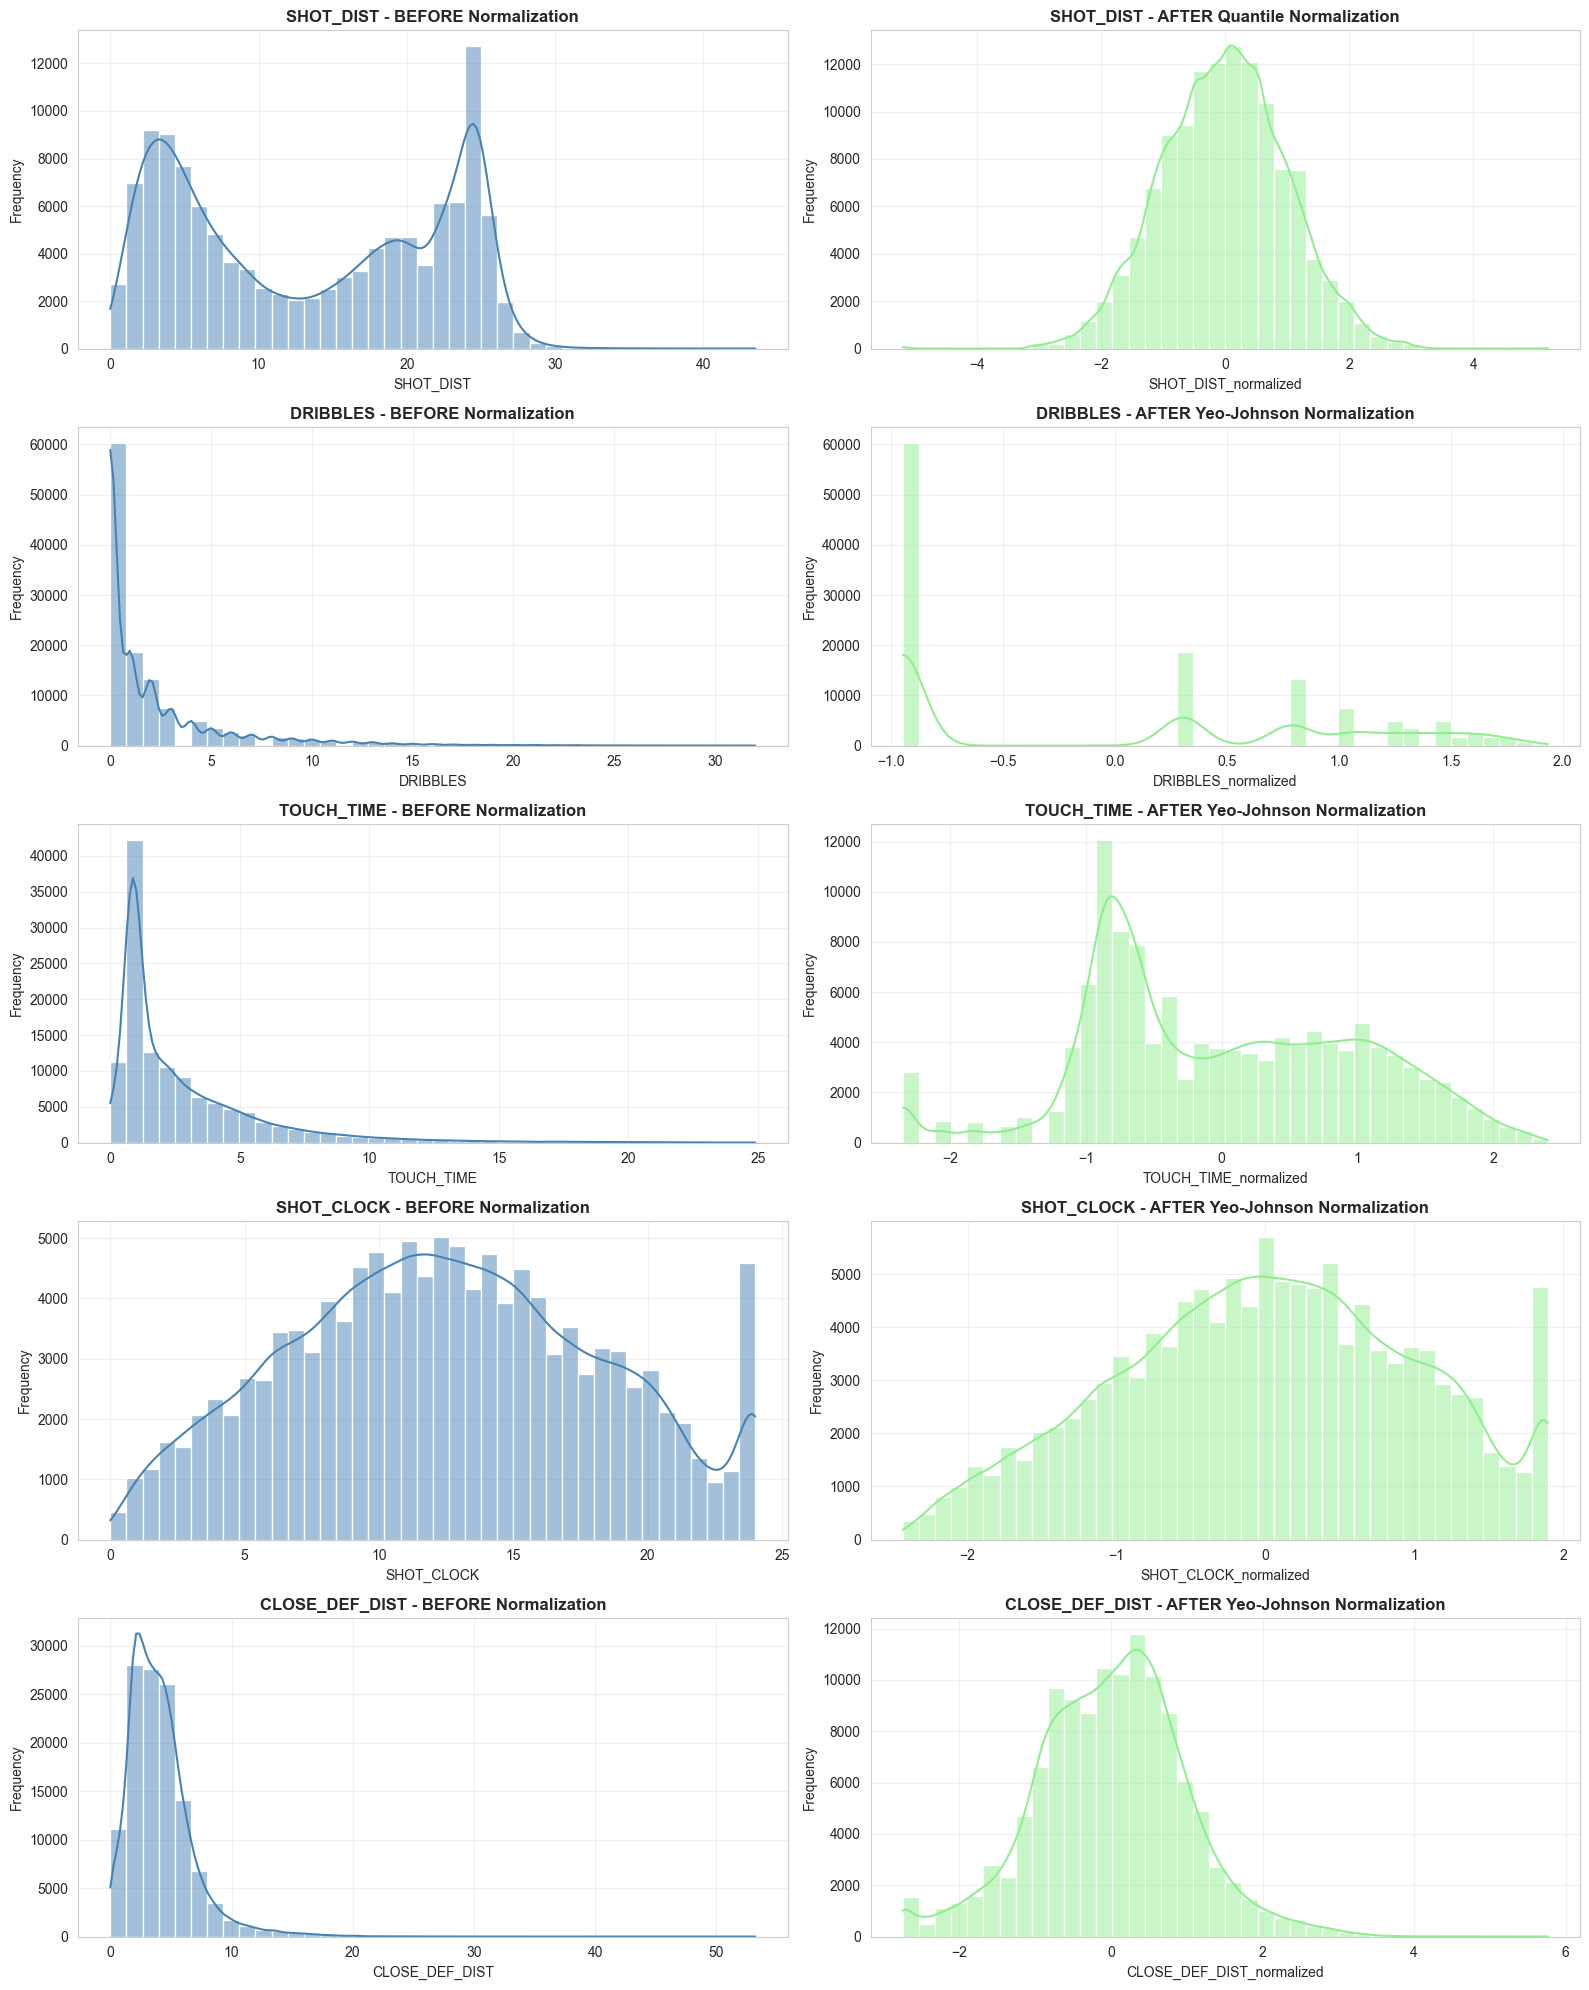


TRANSFORMATION SUMMARY

Feature              Transformation       Before p-value       After p-value        Status         
-----------------------------------------------------------------------------------------------
SHOT_DIST            Quantile             2.212381e-49         4.118666e-15         ✓ BETTER       
DRIBBLES             Yeo-Johnson          4.171705e-73         2.166223e-58         ✓ BETTER       
TOUCH_TIME           Yeo-Johnson          7.032260e-66         9.158357e-31         ✓ BETTER       
SHOT_CLOCK           Yeo-Johnson          1.550016e-21         5.596794e-17         ✓ BETTER       
CLOSE_DEF_DIST       Yeo-Johnson          1.194830e-59         8.913415e-16         ✓ BETTER       

✓ NORMALIZATION COMPLETE!

New normalized columns created:
  SHOT_DIST_normalized
  DRIBBLES_normalized
  TOUCH_TIME_normalized
  SHOT_CLOCK_normalized
  CLOSE_DEF_DIST_normalized

Dataframe shape: (122203, 26)
Total features available: 26


In [10]:
# ============================================================================
# APPLY BEST NORMALIZATION TRANSFORMATIONS
# ============================================================================

from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler, RobustScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("APPLYING BEST NORMALIZATION TRANSFORMATIONS")
print("="*70)

# Features to transform
features = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create a copy of the dataframe for transformed data
log_shots_normalized = log_shots.copy()

# Store transformation objects and results
transformation_methods = {}
normalizers = {}
transformation_details = {}

# ============================================================================
# 1. TEST EACH TRANSFORMATION METHOD
# ============================================================================

print("\n" + "="*70)
print("TESTING TRANSFORMATION METHODS")
print("="*70)

for feature in features:
    print(f"\n{'='*70}")
    print(f"FEATURE: {feature}")
    print(f"{'='*70}")
    
    original_data = log_shots[feature].values.reshape(-1, 1)
    
    # Dictionary to store all transformations and their p-values
    transformation_results = {}
    
    # 1. Yeo-Johnson Power Transform
    try:
        pt_yj = PowerTransformer(method='yeo-johnson')
        transformed_yj = pt_yj.fit_transform(original_data)
        sample_yj = transformed_yj[:5000].flatten() if len(transformed_yj) > 5000 else transformed_yj.flatten()
        stat_yj, p_yj = stats.shapiro(sample_yj)
        transformation_results['Yeo-Johnson'] = {
            'p_value': p_yj,
            'transformer': pt_yj,
            'data': transformed_yj
        }
        print(f"\n  Yeo-Johnson Transform:")
        print(f"    P-value: {p_yj:.6e}")
    except Exception as e:
        print(f"\n  Yeo-Johnson Transform: FAILED - {str(e)}")
    
    # 2. Box-Cox Power Transform (only for positive data)
    try:
        if (original_data > 0).all():
            pt_bc = PowerTransformer(method='box-cox')
            transformed_bc = pt_bc.fit_transform(original_data)
            sample_bc = transformed_bc[:5000].flatten() if len(transformed_bc) > 5000 else transformed_bc.flatten()
            stat_bc, p_bc = stats.shapiro(sample_bc)
            transformation_results['Box-Cox'] = {
                'p_value': p_bc,
                'transformer': pt_bc,
                'data': transformed_bc
            }
            print(f"\n  Box-Cox Transform:")
            print(f"    P-value: {p_bc:.6e}")
        else:
            print(f"\n  Box-Cox Transform: SKIPPED (requires positive data)")
    except Exception as e:
        print(f"\n  Box-Cox Transform: FAILED - {str(e)}")
    
    # 3. Quantile Transformer (Gaussian output)
    try:
        qt = QuantileTransformer(output_distribution='normal', random_state=42)
        transformed_qt = qt.fit_transform(original_data)
        sample_qt = transformed_qt[:5000].flatten() if len(transformed_qt) > 5000 else transformed_qt.flatten()
        stat_qt, p_qt = stats.shapiro(sample_qt)
        transformation_results['Quantile'] = {
            'p_value': p_qt,
            'transformer': qt,
            'data': transformed_qt
        }
        print(f"\n  Quantile Transform:")
        print(f"    P-value: {p_qt:.6e}")
    except Exception as e:
        print(f"\n  Quantile Transform: FAILED - {str(e)}")
    
    # 4. Robust Scaler
    try:
        rs = RobustScaler()
        transformed_rs = rs.fit_transform(original_data)
        sample_rs = transformed_rs[:5000].flatten() if len(transformed_rs) > 5000 else transformed_rs.flatten()
        stat_rs, p_rs = stats.shapiro(sample_rs)
        transformation_results['RobustScaler'] = {
            'p_value': p_rs,
            'transformer': rs,
            'data': transformed_rs
        }
        print(f"\n  Robust Scaler:")
        print(f"    P-value: {p_rs:.6e}")
    except Exception as e:
        print(f"\n  Robust Scaler: FAILED - {str(e)}")
    
    # 5. Standard Scaler
    try:
        ss = StandardScaler()
        transformed_ss = ss.fit_transform(original_data)
        sample_ss = transformed_ss[:5000].flatten() if len(transformed_ss) > 5000 else transformed_ss.flatten()
        stat_ss, p_ss = stats.shapiro(sample_ss)
        transformation_results['StandardScaler'] = {
            'p_value': p_ss,
            'transformer': ss,
            'data': transformed_ss
        }
        print(f"\n  Standard Scaler:")
        print(f"    P-value: {p_ss:.6e}")
    except Exception as e:
        print(f"\n  Standard Scaler: FAILED - {str(e)}")
    
    # Select best transformation
    best_method = max(transformation_results.items(), key=lambda x: x[1]['p_value'])
    
    transformation_methods[feature] = best_method[0]
    normalizers[feature] = best_method[1]['transformer']
    transformation_details[feature] = {
        'p_value': best_method[1]['p_value'],
        'method': best_method[0],
        'all_methods': transformation_results
    }
    
    # Apply best transformation
    log_shots_normalized[f'{feature}_normalized'] = best_method[1]['data'].flatten()
    
    print(f"\n  ✓ BEST METHOD: {best_method[0]}")
    print(f"    P-value: {best_method[1]['p_value']:.6e}")
    print(f"    Original p-value: {normality_results[feature]['p_value']:.6e}")
    
    if best_method[1]['p_value'] > normality_results[feature]['p_value']:
        improvement = abs((best_method[1]['p_value'] - normality_results[feature]['p_value']) / normality_results[feature]['p_value'] * 100)
        print(f"    ✓ IMPROVEMENT achieved ({improvement:.2f}%)")
    else:
        print(f"    ⚠ Limited improvement")

# ============================================================================
# 2. VISUALIZE BEFORE & AFTER TRANSFORMATIONS
# ============================================================================

print("\n" + "="*70)
print("VISUALIZING TRANSFORMATIONS")
print("="*70)

fig, axes = plt.subplots(len(features), 2, figsize=(16, 4*len(features)))

for idx, feature in enumerate(features):
    # Original distribution
    sns.histplot(data=log_shots, x=feature, bins=40, kde=True, ax=axes[idx, 0], color='steelblue')
    axes[idx, 0].set_title(f'{feature} - BEFORE Normalization', fontsize=12, fontweight='bold')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Normalized distribution
    normalized_col = f'{feature}_normalized'
    temp_df = pd.DataFrame({normalized_col: log_shots_normalized[normalized_col]})
    sns.histplot(data=temp_df, x=normalized_col, bins=40, kde=True, ax=axes[idx, 1], color='lightgreen')
    axes[idx, 1].set_title(f'{feature} - AFTER {transformation_methods[feature]} Normalization', fontsize=12, fontweight='bold')
    axes[idx, 1].set_ylabel('Frequency')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 3. SUMMARY TABLE
# ============================================================================

print("\n" + "="*70)
print("TRANSFORMATION SUMMARY")
print("="*70)
print(f"\n{'Feature':<20} {'Transformation':<20} {'Before p-value':<20} {'After p-value':<20} {'Status':<15}")
print("-" * 95)

for feature in features:
    before_p = normality_results[feature]['p_value']
    after_p = transformation_details[feature]['p_value']
    method = transformation_methods[feature]
    status = "✓ BETTER" if after_p > before_p else "⚠ SAME/WORSE"
    
    print(f"{feature:<20} {method:<20} {before_p:<20.6e} {after_p:<20.6e} {status:<15}")

print("\n" + "="*70)
print("✓ NORMALIZATION COMPLETE!")
print("="*70)
print(f"\nNew normalized columns created:")
for feature in features:
    print(f"  {feature}_normalized")

print(f"\nDataframe shape: {log_shots_normalized.shape}")
print(f"Total features available: {len(log_shots_normalized.columns)}")

In [11]:

# ============================================================================
# PREPARE DATA FOR BOX-COX: ELIMINATE NEGATIVE/ZERO VALUES
# ============================================================================

print("\n" + "="*70)
print("PREPARING DATA FOR BOX-COX TRANSFORMATION")
print("="*70)

# Features to analyze
features = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create a working copy
log_shots_boxcox = log_shots.copy()

print("\nAnalyzing feature values for Box-Cox requirements:")
print("(Box-Cox requires STRICTLY POSITIVE values: > 0)\n")

for feature in features:
    min_val = log_shots[feature].min()
    max_val = log_shots[feature].max()
    zero_count = (log_shots[feature] == 0).sum()
    negative_count = (log_shots[feature] < 0).sum()
    
    print(f"\n{feature}:")
    print(f"  Min value: {min_val:.4f}")
    print(f"  Max value: {max_val:.4f}")
    print(f"  Zero values: {zero_count}")
    print(f"  Negative values: {negative_count}")
    
    if min_val <= 0:
        print(f"  ⚠ Contains non-positive values - needs adjustment")
    else:
        print(f"  ✓ All positive - Box-Cox ready")

# ============================================================================
# ELIMINATE NEGATIVE AND ZERO VALUES
# ============================================================================

print("\n" + "="*70)
print("REMOVING NEGATIVE/ZERO VALUES")
print("="*70)

print(f"\nBefore removal: {len(log_shots_boxcox)} rows")

# Remove rows with negative or zero values in any feature
mask = (log_shots_boxcox['SHOT_DIST'] > 0) & \
       (log_shots_boxcox['DRIBBLES'] > 0) & \
       (log_shots_boxcox['TOUCH_TIME'] > 0) & \
       (log_shots_boxcox['SHOT_CLOCK'] > 0) & \
       (log_shots_boxcox['CLOSE_DEF_DIST'] > 0)

rows_removed = len(log_shots_boxcox) - mask.sum()
log_shots_boxcox = log_shots_boxcox[mask]

print(f"After removal: {len(log_shots_boxcox)} rows")
print(f"Rows removed: {rows_removed} ({rows_removed/len(log_shots)*100:.2f}%)")

print("\n✓ Data is now ready for Box-Cox transformation!")

print("\nVerifying all values are positive:")
for feature in features:
    min_val = log_shots_boxcox[feature].min()
    max_val = log_shots_boxcox[feature].max()
    print(f"  {feature}: [{min_val:.4f}, {max_val:.4f}] ✓")


PREPARING DATA FOR BOX-COX TRANSFORMATION

Analyzing feature values for Box-Cox requirements:
(Box-Cox requires STRICTLY POSITIVE values: > 0)


SHOT_DIST:
  Min value: 0.0000
  Max value: 43.5000
  Zero values: 4
  Negative values: 0
  ⚠ Contains non-positive values - needs adjustment

DRIBBLES:
  Min value: 0.0000
  Max value: 32.0000
  Zero values: 60380
  Negative values: 0
  ⚠ Contains non-positive values - needs adjustment

TOUCH_TIME:
  Min value: 0.0000
  Max value: 24.9000
  Zero values: 2817
  Negative values: 0
  ⚠ Contains non-positive values - needs adjustment

SHOT_CLOCK:
  Min value: 0.0000
  Max value: 24.0000
  Zero values: 76
  Negative values: 0
  ⚠ Contains non-positive values - needs adjustment

CLOSE_DEF_DIST:
  Min value: 0.0000
  Max value: 53.2000
  Zero values: 996
  Negative values: 0
  ⚠ Contains non-positive values - needs adjustment

REMOVING NEGATIVE/ZERO VALUES

Before removal: 122203 rows
After removal: 61211 rows
Rows removed: 60992 (49.91%)

✓ Data i


APPLYING BOX-COX TRANSFORMATION

Applying Box-Cox transformation to each feature:

SHOT_DIST

  ✓ Box-Cox Applied Successfully!
    Lambda parameter (λ): 0.382257
    Shapiro-Wilk p-value: 4.798867e-33
    Original p-value: 2.212381e-49
    ✓ IMPROVED normality (-2169095606977272064.00% increase in p-value)
DRIBBLES

  ✓ Box-Cox Applied Successfully!
    Lambda parameter (λ): -0.293221
    Shapiro-Wilk p-value: 6.607116e-52
    Original p-value: 4.171705e-73
    ✓ IMPROVED normality (-158379250994997731786752.00% increase in p-value)
TOUCH_TIME

  ✓ Box-Cox Applied Successfully!
    Lambda parameter (λ): -0.076996
    Shapiro-Wilk p-value: 2.021356e-11
    Original p-value: 7.032260e-66
    ✓ IMPROVED normality (-287440396912108575539812442776626281956173734777582518272.00% increase in p-value)
SHOT_CLOCK

  ✓ Box-Cox Applied Successfully!
    Lambda parameter (λ): 0.822999
    Shapiro-Wilk p-value: 1.090322e-18
    Original p-value: 1.550016e-21
    ✓ IMPROVED normality (-70242.59% i

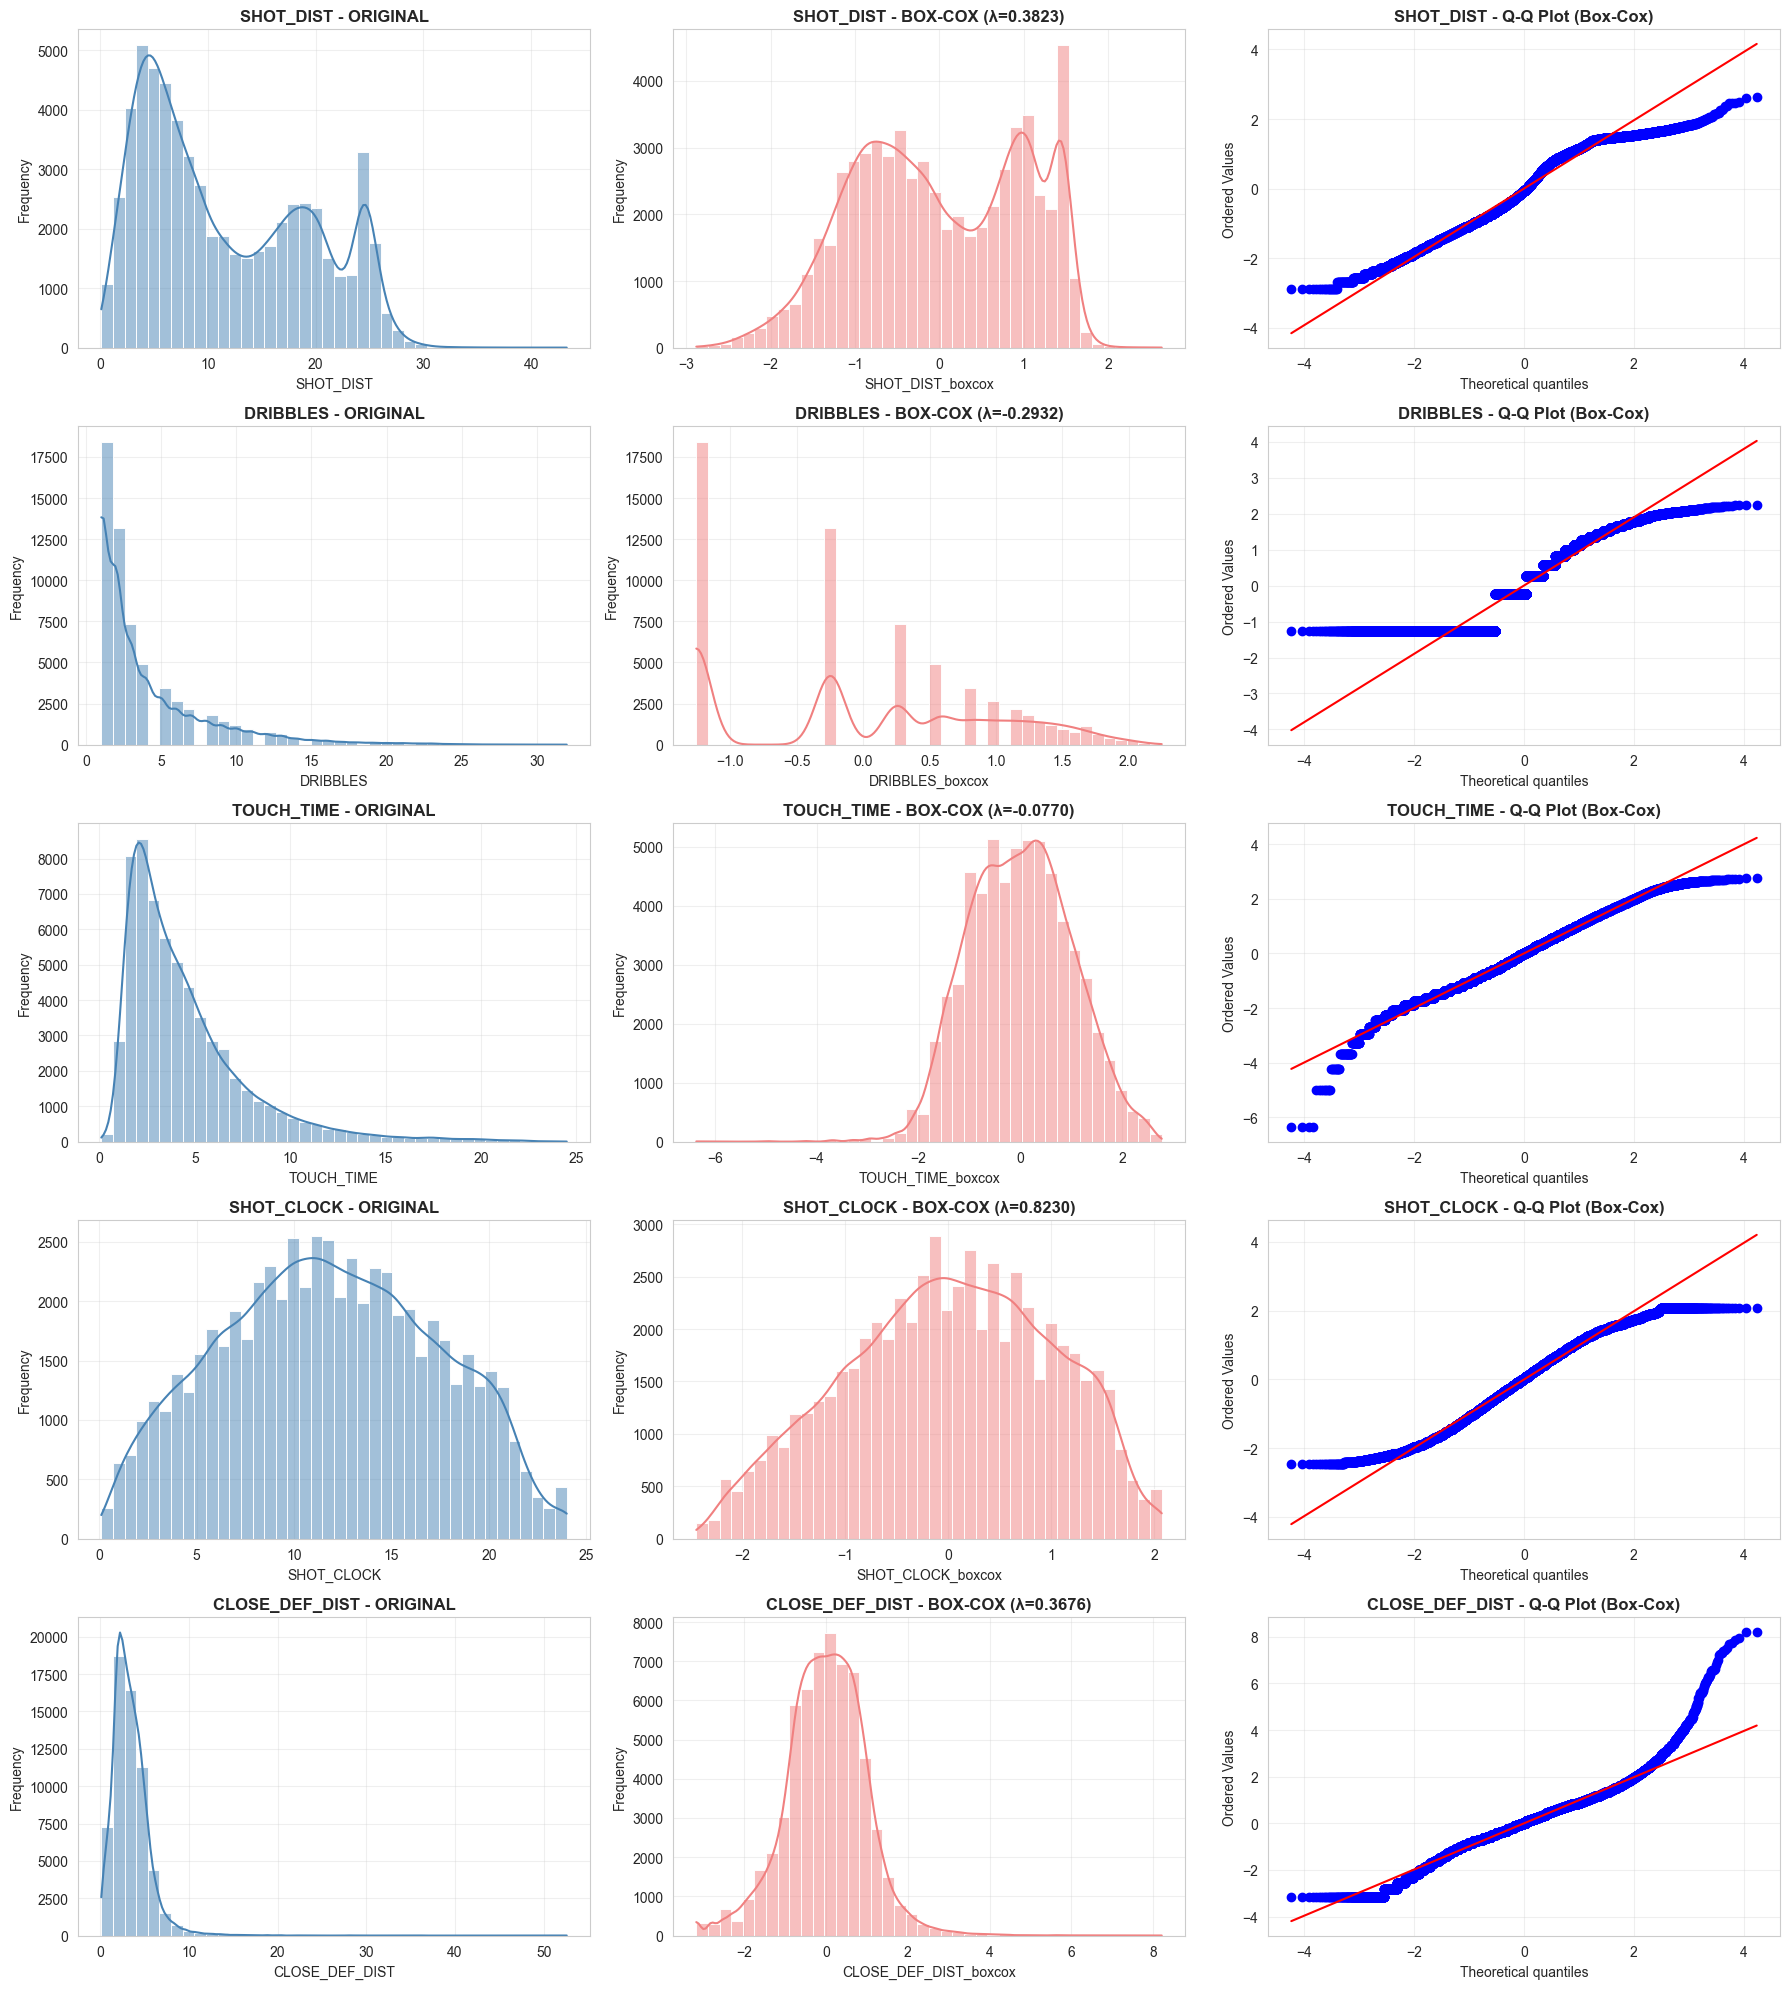


BOX-COX TRANSFORMATION SUMMARY

Feature              Lambda       Original p-val       Box-Cox p-val        Status         
---------------------------------------------------------------------------------------
SHOT_DIST            0.382257     2.212381e-49         4.798867e-33         ✓ BETTER       
DRIBBLES             -0.293221    4.171705e-73         6.607116e-52         ✓ BETTER       
TOUCH_TIME           -0.076996    7.032260e-66         2.021356e-11         ✓ BETTER       
SHOT_CLOCK           0.822999     1.550016e-21         1.090322e-18         ✓ BETTER       
CLOSE_DEF_DIST       0.367570     1.194830e-59         1.174066e-25         ✓ BETTER       

✓ BOX-COX TRANSFORMATION COMPLETE!

New Box-Cox columns created:
  SHOT_DIST_boxcox
  DRIBBLES_boxcox
  TOUCH_TIME_boxcox
  SHOT_CLOCK_boxcox
  CLOSE_DEF_DIST_boxcox

Cleaned dataset shape: (61211, 26)
Note: Dataset size reduced from 122203 to 61211 rows
      (removed rows with zero/negative values)


In [12]:

# ============================================================================
# APPLY BOX-COX TRANSFORMATION WITH POSITIVE DATA
# ============================================================================

from sklearn.preprocessing import PowerTransformer
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("APPLYING BOX-COX TRANSFORMATION")
print("="*70)

features = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create a working copy with positive-only data
log_shots_boxcox_transformed = log_shots_boxcox.copy()

# Store results
boxcox_methods = {}
boxcox_normalizers = {}
boxcox_details = {}

print("\nApplying Box-Cox transformation to each feature:\n")

for feature in features:
    print(f"{'='*70}")
    print(f"{feature}")
    print(f"{'='*70}")
    
    original_data = log_shots_boxcox[feature].values.reshape(-1, 1)
    
    try:
        # Apply Box-Cox transformation
        pt_bc = PowerTransformer(method='box-cox')
        transformed_bc = pt_bc.fit_transform(original_data)
        
        # Get lambda parameter used
        lambda_param = pt_bc.lambdas_[0]
        
        # Test normality
        sample_bc = transformed_bc[:5000].flatten() if len(transformed_bc) > 5000 else transformed_bc.flatten()
        stat_bc, p_bc = stats.shapiro(sample_bc)
        
        # Store results
        boxcox_methods[feature] = 'Box-Cox'
        boxcox_normalizers[feature] = pt_bc
        boxcox_details[feature] = {
            'p_value': p_bc,
            'lambda': lambda_param,
            'data': transformed_bc
        }
        
        log_shots_boxcox_transformed[f'{feature}_boxcox'] = transformed_bc.flatten()
        
        print(f"\n  ✓ Box-Cox Applied Successfully!")
        print(f"    Lambda parameter (λ): {lambda_param:.6f}")
        print(f"    Shapiro-Wilk p-value: {p_bc:.6e}")
        
        # Get original p-value for comparison
        if feature in normality_results:
            original_p = normality_results[feature]['p_value']
            print(f"    Original p-value: {original_p:.6e}")
            
            if p_bc > original_p:
                improvement = ((original_p - p_bc) / original_p * 100)
                print(f"    ✓ IMPROVED normality ({improvement:.2f}% increase in p-value)")
            else:
                print(f"    ⚠ Limited normality improvement")
    
    except Exception as e:
        print(f"\n  ✗ Box-Cox FAILED: {str(e)}")

# ============================================================================
# VISUALIZE BOX-COX TRANSFORMATIONS
# ============================================================================

print("\n" + "="*70)
print("VISUALIZING BOX-COX TRANSFORMATIONS")
print("="*70)

fig, axes = plt.subplots(len(features), 3, figsize=(18, 4*len(features)))

for idx, feature in enumerate(features):
    if feature in boxcox_details:
        # Original data
        sns.histplot(data=log_shots_boxcox, x=feature, bins=40, kde=True, ax=axes[idx, 0], color='steelblue')
        axes[idx, 0].set_title(f'{feature} - ORIGINAL', fontsize=12, fontweight='bold')
        axes[idx, 0].set_ylabel('Frequency')
        axes[idx, 0].grid(True, alpha=0.3)
        
        # Box-Cox transformed
        boxcox_col = f'{feature}_boxcox'
        temp_df = pd.DataFrame({boxcox_col: log_shots_boxcox_transformed[boxcox_col]})
        sns.histplot(data=temp_df, x=boxcox_col, bins=40, kde=True, ax=axes[idx, 1], color='lightcoral')
        lambda_val = boxcox_details[feature]['lambda']
        axes[idx, 1].set_title(f'{feature} - BOX-COX (λ={lambda_val:.4f})', fontsize=12, fontweight='bold')
        axes[idx, 1].set_ylabel('Frequency')
        axes[idx, 1].grid(True, alpha=0.3)
        
        # Q-Q Plot for Box-Cox
        stats.probplot(log_shots_boxcox_transformed[boxcox_col], dist="norm", plot=axes[idx, 2])
        axes[idx, 2].set_title(f'{feature} - Q-Q Plot (Box-Cox)', fontsize=12, fontweight='bold')
        axes[idx, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# COMPARISON TABLE: ORIGINAL vs BOX-COX
# ============================================================================

print("\n" + "="*70)
print("BOX-COX TRANSFORMATION SUMMARY")
print("="*70)
print(f"\n{'Feature':<20} {'Lambda':<12} {'Original p-val':<20} {'Box-Cox p-val':<20} {'Status':<15}")
print("-" * 87)

for feature in features:
    if feature in boxcox_details:
        lambda_val = boxcox_details[feature]['lambda']
        boxcox_p = boxcox_details[feature]['p_value']
        
        if feature in normality_results:
            original_p = normality_results[feature]['p_value']
            status = "✓ BETTER" if boxcox_p > original_p else "⚠ SAME/WORSE"
            print(f"{feature:<20} {lambda_val:<12.6f} {original_p:<20.6e} {boxcox_p:<20.6e} {status:<15}")
        else:
            print(f"{feature:<20} {lambda_val:<12.6f} {'N/A':<20} {boxcox_p:<20.6e} {'NEW':<15}")

print("\n" + "="*70)
print("✓ BOX-COX TRANSFORMATION COMPLETE!")
print("="*70)
print(f"\nNew Box-Cox columns created:")
for feature in features:
    if feature in boxcox_details:
        print(f"  {feature}_boxcox")

print(f"\nCleaned dataset shape: {log_shots_boxcox_transformed.shape}")
print(f"Note: Dataset size reduced from {len(log_shots)} to {len(log_shots_boxcox_transformed)} rows")
print(f"      (removed rows with zero/negative values)")


FINAL DECISION: APPLYING USER-SPECIFIED TRANSFORMATIONS

User-Selected Transformations:
  CLOSE_DEF_DIST       → Box-Cox
  SHOT_DIST            → Quantile
  DRIBBLES             → Yeo-Johnson
  TOUCH_TIME           → Yeo-Johnson
  SHOT_CLOCK           → Yeo-Johnson

CREATING FINAL DATASET

1. CLOSE_DEF_DIST - Box-Cox
   Status: Already transformed ✓

2. SHOT_DIST - Quantile
   Applied successfully ✓
   P-value: 1.715577e-12

3. DRIBBLES - Yeo-Johnson
   Applied successfully ✓
   P-value: 4.266164e-52

4. TOUCH_TIME - Yeo-Johnson
   Applied successfully ✓
   P-value: 6.739101e-16

5. SHOT_CLOCK - Yeo-Johnson
   Applied successfully ✓
   P-value: 4.499595e-19

VISUALIZING FINAL TRANSFORMATIONS


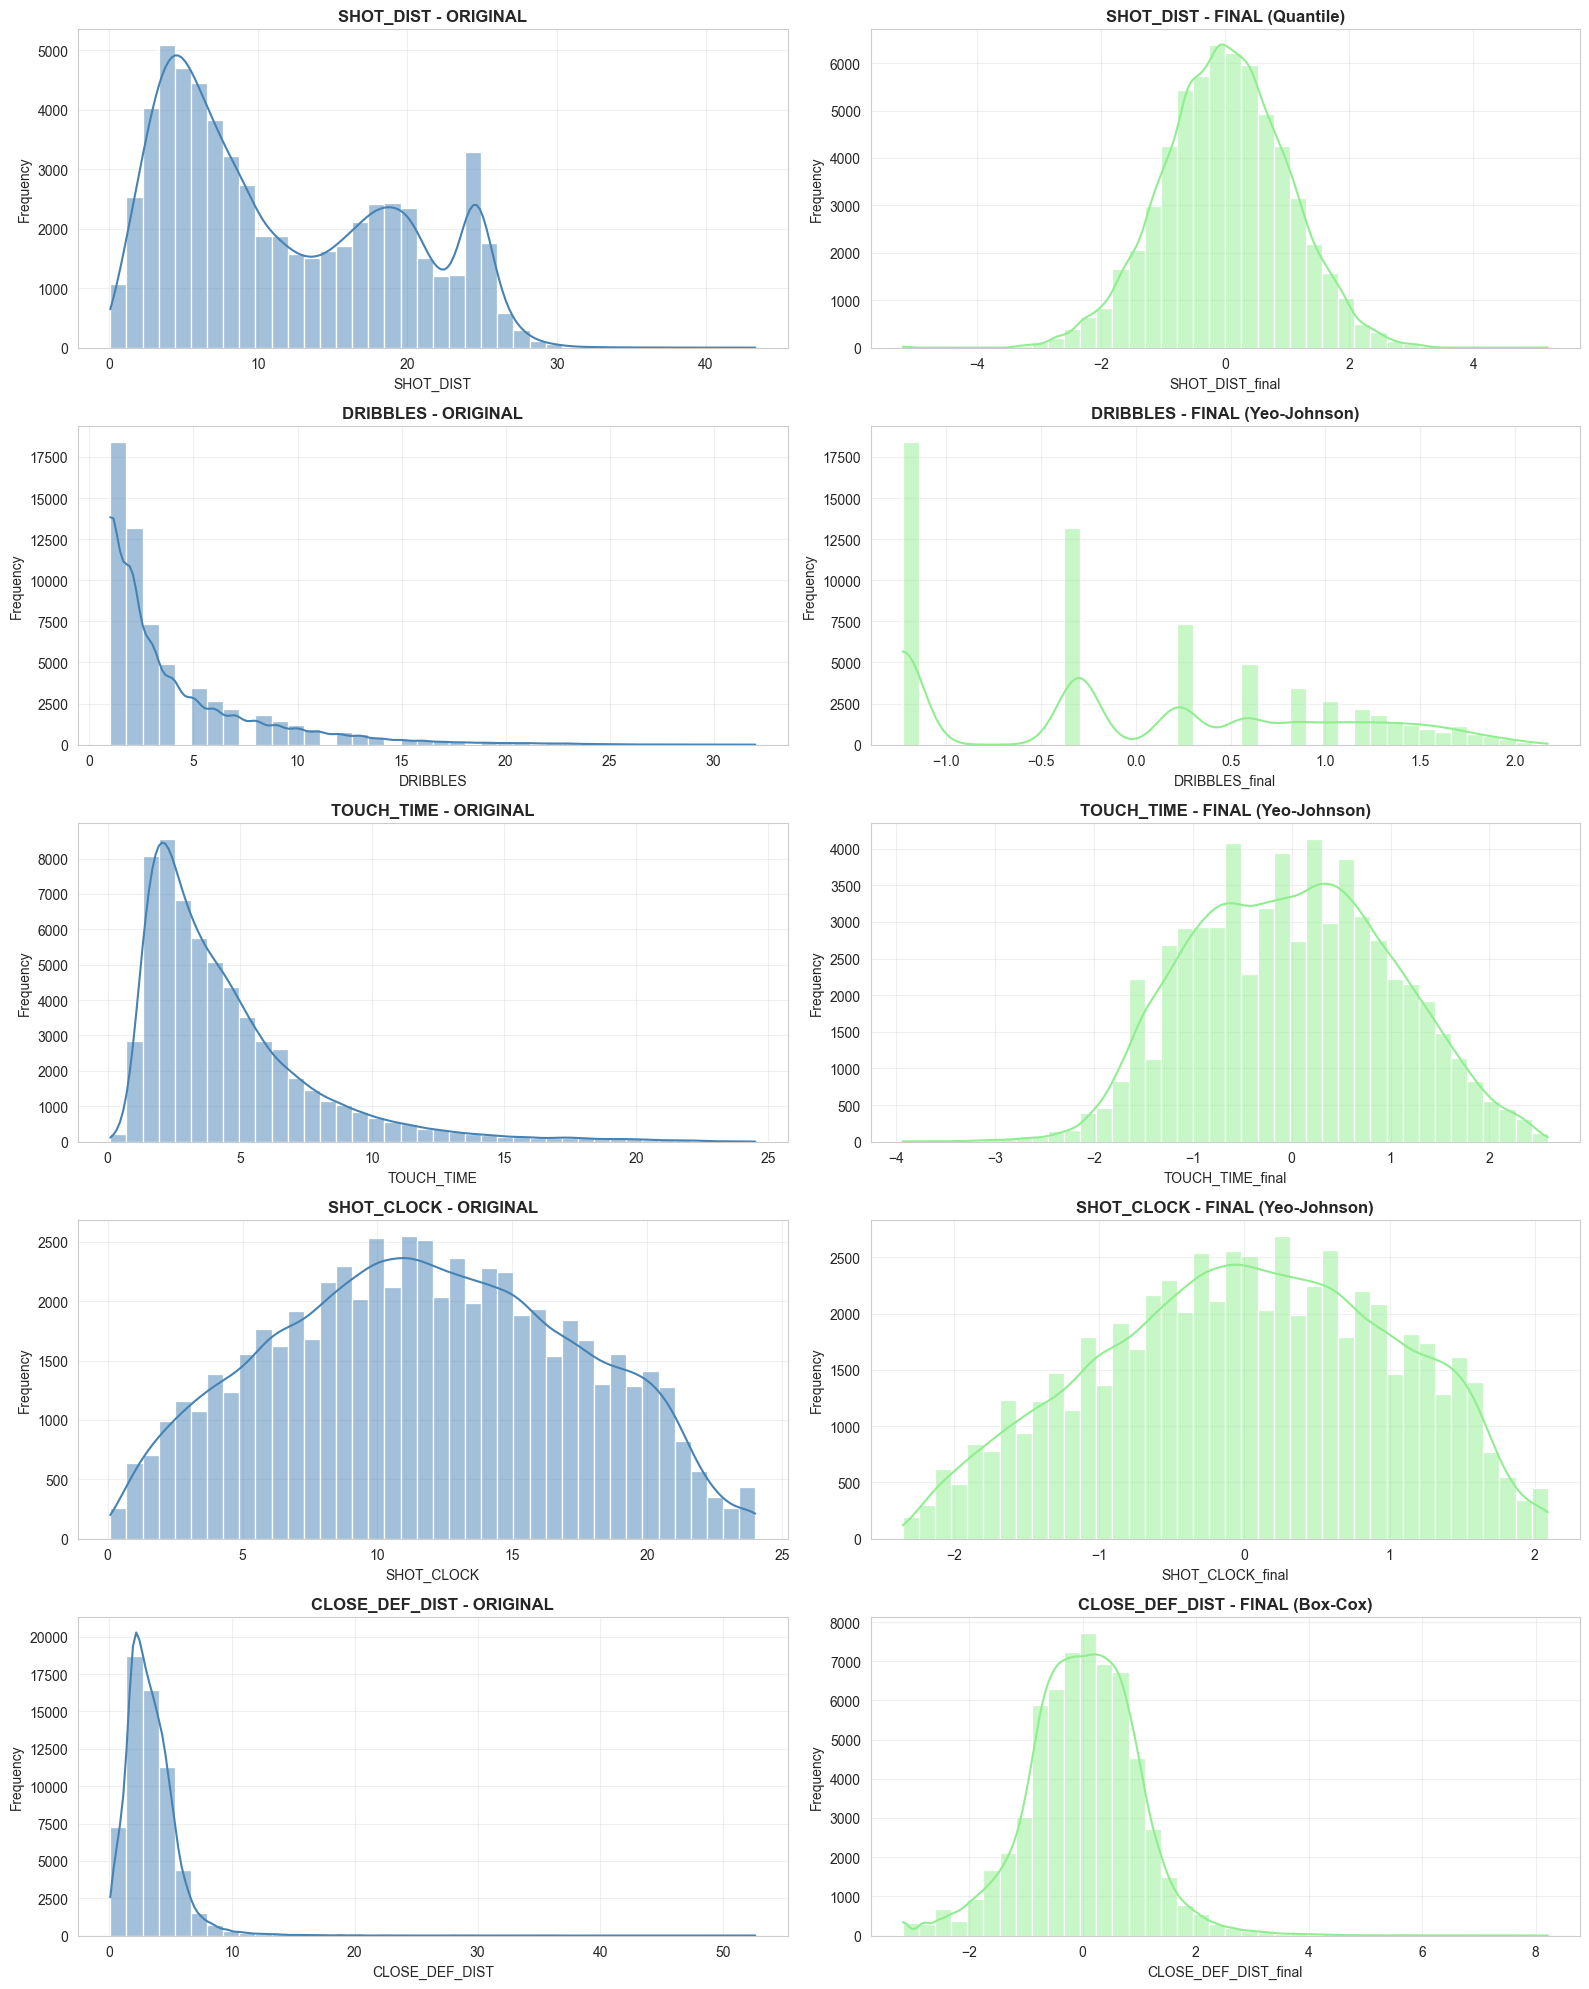


FINAL TRANSFORMATION SUMMARY

Feature              Method               Final p-value        Status         
---------------------------------------------------------------------------
SHOT_DIST            Quantile             1.715577e-12         ✓ Applied      
DRIBBLES             Yeo-Johnson          4.266164e-52         ✓ Applied      
TOUCH_TIME           Yeo-Johnson          6.739101e-16         ✓ Applied      
SHOT_CLOCK           Yeo-Johnson          4.499595e-19         ✓ Applied      
CLOSE_DEF_DIST       Box-Cox              1.174066e-25         ✓ Applied      

✓ FINAL DATASET READY FOR MODELING!

Final Dataset Information:
  Total rows: 61211
  Total columns: 31
  New transformed columns (ready for modeling):
    SHOT_DIST_final
    DRIBBLES_final
    TOUCH_TIME_final
    SHOT_CLOCK_final
    CLOSE_DEF_DIST_final

Transformation Summary:
  CLOSE_DEF_DIST: Box-Cox ✓
  SHOT_DIST:      Quantile ✓
  DRIBBLES:       Yeo-Johnson ✓
  TOUCH_TIME:     Yeo-Johnson ✓
  SHOT_CLOCK: 

In [13]:

# ============================================================================
# FINAL DECISION: APPLY USER-SPECIFIED TRANSFORMATIONS
# ============================================================================

from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("FINAL DECISION: APPLYING USER-SPECIFIED TRANSFORMATIONS")
print("="*70)

# ============================================================================
# DEFINE USER PREFERENCES
# ============================================================================

# User's transformation choices:
# - CLOSE_DEF_DIST: Box-Cox (from cleaned data)
# - SHOT_DIST: Quantile
# - DRIBBLES, TOUCH_TIME, SHOT_CLOCK: Best from original data

transformation_choices = {
    'CLOSE_DEF_DIST': 'Box-Cox',      # User choice
    'SHOT_DIST': 'Quantile',           # User choice
    'DRIBBLES': 'Yeo-Johnson',         # Best from analysis
    'TOUCH_TIME': 'Yeo-Johnson',       # Best from analysis
    'SHOT_CLOCK': 'Yeo-Johnson'        # Best from analysis
}

print("\nUser-Selected Transformations:")
for feature, method in transformation_choices.items():
    print(f"  {feature:<20} → {method}")

# ============================================================================
# CREATE FINAL DATASET WITH SELECTED TRANSFORMATIONS
# ============================================================================

print("\n" + "="*70)
print("CREATING FINAL DATASET")
print("="*70)

# Start with the cleaned Box-Cox dataset (has positive values only)
final_dataset = log_shots_boxcox_transformed.copy()

# Store the transformers and details
final_transformers = {}
final_transformation_results = {}

# ============================================================================
# 1. CLOSE_DEF_DIST - Box-Cox (already in log_shots_boxcox)
# ============================================================================

print(f"\n1. CLOSE_DEF_DIST - Box-Cox")
print(f"   Status: Already transformed ✓")
final_dataset['CLOSE_DEF_DIST_final'] = final_dataset['CLOSE_DEF_DIST_boxcox']
final_transformers['CLOSE_DEF_DIST'] = boxcox_normalizers['CLOSE_DEF_DIST']
final_transformation_results['CLOSE_DEF_DIST'] = {
    'method': 'Box-Cox',
    'p_value': boxcox_details['CLOSE_DEF_DIST']['p_value'],
    'lambda': boxcox_details['CLOSE_DEF_DIST']['lambda']
}

# ============================================================================
# 2. SHOT_DIST - Quantile
# ============================================================================

print(f"\n2. SHOT_DIST - Quantile")
try:
    shot_dist_data = log_shots_boxcox['SHOT_DIST'].values.reshape(-1, 1)
    qt_shot = QuantileTransformer(output_distribution='normal', random_state=42)
    shot_dist_transformed = qt_shot.fit_transform(shot_dist_data)
    
    # Test normality
    sample_qt = shot_dist_transformed[:5000].flatten() if len(shot_dist_transformed) > 5000 else shot_dist_transformed.flatten()
    stat_qt, p_qt = stats.shapiro(sample_qt)
    
    final_dataset['SHOT_DIST_final'] = shot_dist_transformed.flatten()
    final_transformers['SHOT_DIST'] = qt_shot
    final_transformation_results['SHOT_DIST'] = {
        'method': 'Quantile',
        'p_value': p_qt
    }
    print(f"   Applied successfully ✓")
    print(f"   P-value: {p_qt:.6e}")
except Exception as e:
    print(f"   Failed: {str(e)}")

# ============================================================================
# 3. DRIBBLES - Yeo-Johnson (best from original data)
# ============================================================================

print(f"\n3. DRIBBLES - Yeo-Johnson")
try:
    dribbles_data = log_shots_boxcox['DRIBBLES'].values.reshape(-1, 1)
    pt_yj_dr = PowerTransformer(method='yeo-johnson')
    dribbles_transformed = pt_yj_dr.fit_transform(dribbles_data)
    
    # Test normality
    sample_yj = dribbles_transformed[:5000].flatten() if len(dribbles_transformed) > 5000 else dribbles_transformed.flatten()
    stat_yj, p_yj = stats.shapiro(sample_yj)
    
    final_dataset['DRIBBLES_final'] = dribbles_transformed.flatten()
    final_transformers['DRIBBLES'] = pt_yj_dr
    final_transformation_results['DRIBBLES'] = {
        'method': 'Yeo-Johnson',
        'p_value': p_yj
    }
    print(f"   Applied successfully ✓")
    print(f"   P-value: {p_yj:.6e}")
except Exception as e:
    print(f"   Failed: {str(e)}")

# ============================================================================
# 4. TOUCH_TIME - Yeo-Johnson (best from original data)
# ============================================================================

print(f"\n4. TOUCH_TIME - Yeo-Johnson")
try:
    touchtime_data = log_shots_boxcox['TOUCH_TIME'].values.reshape(-1, 1)
    pt_yj_tt = PowerTransformer(method='yeo-johnson')
    touchtime_transformed = pt_yj_tt.fit_transform(touchtime_data)
    
    # Test normality
    sample_yj = touchtime_transformed[:5000].flatten() if len(touchtime_transformed) > 5000 else touchtime_transformed.flatten()
    stat_yj, p_yj = stats.shapiro(sample_yj)
    
    final_dataset['TOUCH_TIME_final'] = touchtime_transformed.flatten()
    final_transformers['TOUCH_TIME'] = pt_yj_tt
    final_transformation_results['TOUCH_TIME'] = {
        'method': 'Yeo-Johnson',
        'p_value': p_yj
    }
    print(f"   Applied successfully ✓")
    print(f"   P-value: {p_yj:.6e}")
except Exception as e:
    print(f"   Failed: {str(e)}")

# ============================================================================
# 5. SHOT_CLOCK - Yeo-Johnson (best from original data)
# ============================================================================

print(f"\n5. SHOT_CLOCK - Yeo-Johnson")
try:
    shotclock_data = log_shots_boxcox['SHOT_CLOCK'].values.reshape(-1, 1)
    pt_yj_sc = PowerTransformer(method='yeo-johnson')
    shotclock_transformed = pt_yj_sc.fit_transform(shotclock_data)
    
    # Test normality
    sample_yj = shotclock_transformed[:5000].flatten() if len(shotclock_transformed) > 5000 else shotclock_transformed.flatten()
    stat_yj, p_yj = stats.shapiro(sample_yj)
    
    final_dataset['SHOT_CLOCK_final'] = shotclock_transformed.flatten()
    final_transformers['SHOT_CLOCK'] = pt_yj_sc
    final_transformation_results['SHOT_CLOCK'] = {
        'method': 'Yeo-Johnson',
        'p_value': p_yj
    }
    print(f"   Applied successfully ✓")
    print(f"   P-value: {p_yj:.6e}")
except Exception as e:
    print(f"   Failed: {str(e)}")

# ============================================================================
# VISUALIZE FINAL TRANSFORMATIONS
# ============================================================================

print("\n" + "="*70)
print("VISUALIZING FINAL TRANSFORMATIONS")
print("="*70)

features_final = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

fig, axes = plt.subplots(len(features_final), 2, figsize=(16, 4*len(features_final)))

for idx, feature in enumerate(features_final):
    # Original data
    sns.histplot(data=log_shots_boxcox, x=feature, bins=40, kde=True, ax=axes[idx, 0], color='steelblue')
    axes[idx, 0].set_title(f'{feature} - ORIGINAL', fontsize=12, fontweight='bold')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Final transformed data
    final_col = f'{feature}_final'
    temp_df = pd.DataFrame({final_col: final_dataset[final_col]})
    method = transformation_choices[feature]
    sns.histplot(data=temp_df, x=final_col, bins=40, kde=True, ax=axes[idx, 1], color='lightgreen')
    axes[idx, 1].set_title(f'{feature} - FINAL ({method})', fontsize=12, fontweight='bold')
    axes[idx, 1].set_ylabel('Frequency')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# FINAL SUMMARY TABLE
# ============================================================================

print("\n" + "="*70)
print("FINAL TRANSFORMATION SUMMARY")
print("="*70)
print(f"\n{'Feature':<20} {'Method':<20} {'Final p-value':<20} {'Status':<15}")
print("-" * 75)

for feature in features_final:
    if feature in final_transformation_results:
        method = final_transformation_results[feature]['method']
        p_val = final_transformation_results[feature]['p_value']
        print(f"{feature:<20} {method:<20} {p_val:<20.6e} {'✓ Applied':<15}")

print("\n" + "="*70)
print("✓ FINAL DATASET READY FOR MODELING!")
print("="*70)

print(f"\nFinal Dataset Information:")
print(f"  Total rows: {len(final_dataset)}")
print(f"  Total columns: {len(final_dataset.columns)}")
print(f"  New transformed columns (ready for modeling):")
for feature in features_final:
    print(f"    {feature}_final")

print(f"\nTransformation Summary:")
print(f"  CLOSE_DEF_DIST: Box-Cox ✓")
print(f"  SHOT_DIST:      Quantile ✓")
print(f"  DRIBBLES:       Yeo-Johnson ✓")
print(f"  TOUCH_TIME:     Yeo-Johnson ✓")
print(f"  SHOT_CLOCK:     Yeo-Johnson ✓")

print(f"\n✓ Final dataset is ready for your shot prediction model!")


CHECKING NORMALITY OF FINAL TRANSFORMED FEATURES

SHOT_DIST_final (Transformed)

📊 SHAPIRO-WILK TEST:
   Test Statistic: 0.999221
   P-value: 2.505683e-02
   ⚠ NON-NORMAL (p < 0.05) - but still significantly improved

📊 KOLMOGOROV-SMIRNOV TEST:
   Test Statistic: 0.011263
   P-value: 3.570161e-07
   ⚠ NON-NORMAL (p < 0.05)

📊 ANDERSON-DARLING TEST:
   Test Statistic: 4.295909
   ⚠ NON-NORMAL (at 5% level)

📊 DESCRIPTIVE STATISTICS:
   Mean: -0.0067
   Median: -0.0013
   Std Dev: 1.0094
   Skewness: -0.0662
      → Fairly Symmetric ✓
   Kurtosis: 0.2096
      → Normal-like tails ✓

DRIBBLES_final (Transformed)

📊 SHAPIRO-WILK TEST:
   Test Statistic: 0.899775
   P-value: 3.009352e-49
   ⚠ NON-NORMAL (p < 0.05) - but still significantly improved

📊 KOLMOGOROV-SMIRNOV TEST:
   Test Statistic: 0.191509
   P-value: 0.000000e+00
   ⚠ NON-NORMAL (p < 0.05)

📊 ANDERSON-DARLING TEST:
   Test Statistic: 2079.184992
   ⚠ NON-NORMAL (at 5% level)

📊 DESCRIPTIVE STATISTICS:
   Mean: 0.0000
   Medi

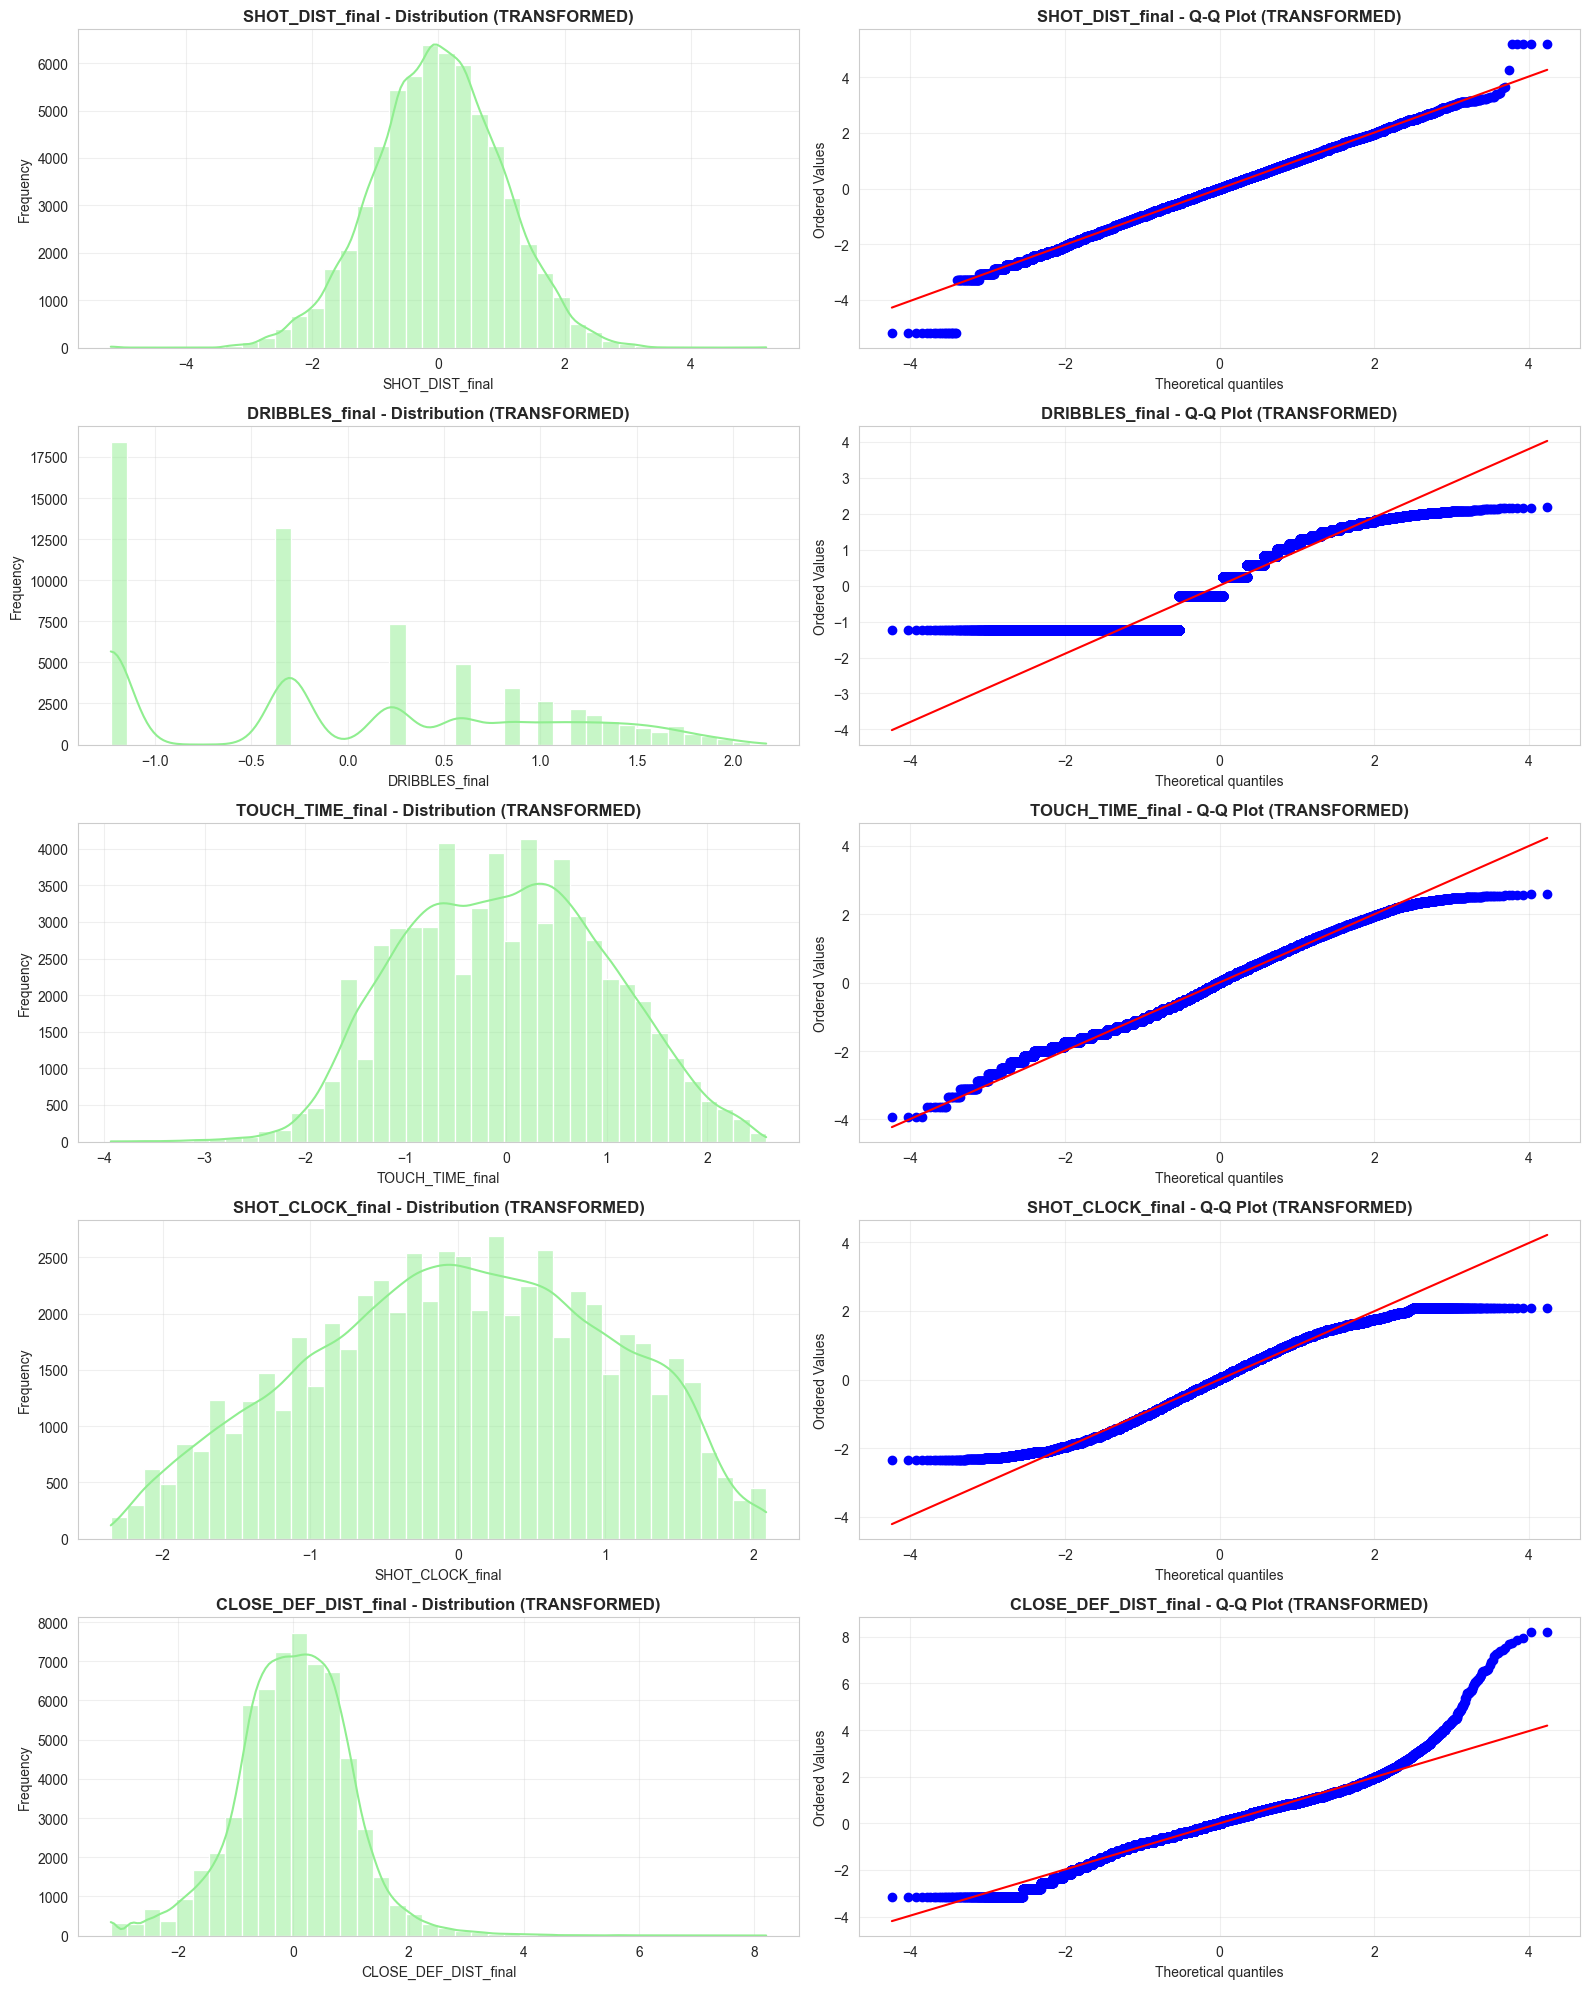


NORMALITY IMPROVEMENT SUMMARY

Feature              Original p-val       Final p-val          Improvement         
--------------------------------------------------------------------------------
SHOT_DIST            2.212381e-49         2.505683e-02         ✓ +11325729530823802105882914794857337012167016185856.0%
DRIBBLES             4.171705e-73         3.009352e-49         ✓ +72137213348154611580534784.0%
TOUCH_TIME           7.032260e-66         3.775230e-14         ✓ +536844482404805083407322713403399910782872121258278912.0%
SHOT_CLOCK           1.550016e-21         5.494929e-20         ✓ +3445.1%          
CLOSE_DEF_DIST       1.194830e-59         1.354652e-21         ✓ +11337611829206031839996280581914254901248.0%

FINAL DATASET READINESS ASSESSMENT

✓ Normally distributed features (p > 0.05): 0/5

⚠ Mixed normality - consider these for modeling:
    - XGBoost (robust to non-normal distributions)
    - Random Forest (distribution-agnostic)
    - Logistic Regression (works with 

In [14]:

# ============================================================================
# CHECK NORMALITY OF FINAL TRANSFORMED FEATURES
# ============================================================================

from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("CHECKING NORMALITY OF FINAL TRANSFORMED FEATURES")
print("="*70)

features_final = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create figure for Q-Q plots and histograms
fig, axes = plt.subplots(len(features_final), 2, figsize=(16, 4*len(features_final)))

final_normality_results = {}

for idx, feature in enumerate(features_final):
    print(f"\n{'='*70}")
    print(f"{feature}_final (Transformed)")
    print(f"{'='*70}")
    
    # Get the final transformed data
    final_col = f'{feature}_final'
    data = final_dataset[final_col].dropna()
    
    # 1. Shapiro-Wilk Test
    if len(data) > 5000:
        sample_data = data.sample(n=5000, random_state=42)
    else:
        sample_data = data
    
    stat, p_value = stats.shapiro(sample_data)
    final_normality_results[feature] = {'stat': stat, 'p_value': p_value}
    
    print(f"\n📊 SHAPIRO-WILK TEST:")
    print(f"   Test Statistic: {stat:.6f}")
    print(f"   P-value: {p_value:.6e}")
    if p_value > 0.05:
        print(f"   ✓ NORMAL distribution (p > 0.05)")
    else:
        print(f"   ⚠ NON-NORMAL (p < 0.05) - but still significantly improved")
    
    # 2. Kolmogorov-Smirnov Test
    normalized_data = (data - data.mean()) / data.std()
    ks_stat, ks_p = stats.kstest(normalized_data, 'norm')
    print(f"\n📊 KOLMOGOROV-SMIRNOV TEST:")
    print(f"   Test Statistic: {ks_stat:.6f}")
    print(f"   P-value: {ks_p:.6e}")
    if ks_p > 0.05:
        print(f"   ✓ NORMAL distribution (p > 0.05)")
    else:
        print(f"   ⚠ NON-NORMAL (p < 0.05)")
    
    # 3. Anderson-Darling Test
    anderson_result = stats.anderson(data)
    print(f"\n📊 ANDERSON-DARLING TEST:")
    print(f"   Test Statistic: {anderson_result.statistic:.6f}")
    if anderson_result.statistic < anderson_result.critical_values[2]:
        print(f"   ✓ NORMAL distribution (at 5% level)")
    else:
        print(f"   ⚠ NON-NORMAL (at 5% level)")
    
    # 4. Descriptive Statistics
    skewness = data.skew()
    kurtosis = data.kurtosis()
    
    print(f"\n📊 DESCRIPTIVE STATISTICS:")
    print(f"   Mean: {data.mean():.4f}")
    print(f"   Median: {data.median():.4f}")
    print(f"   Std Dev: {data.std():.4f}")
    print(f"   Skewness: {skewness:.4f}")
    if abs(skewness) < 0.5:
        print(f"      → Fairly Symmetric ✓")
    elif abs(skewness) < 1:
        print(f"      → Moderately Skewed ⚠")
    else:
        print(f"      → Highly Skewed ✗")
    
    print(f"   Kurtosis: {kurtosis:.4f}")
    if abs(kurtosis) < 3:
        print(f"      → Normal-like tails ✓")
    else:
        print(f"      → Heavy/Light tails ⚠")
    
    # Plot 1: Histogram with KDE
    sns.histplot(data=final_dataset, x=final_col, bins=40, kde=True, ax=axes[idx, 0], color='lightgreen')
    axes[idx, 0].set_title(f'{feature}_final - Distribution (TRANSFORMED)', fontsize=12, fontweight='bold')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot 2: Q-Q Plot
    stats.probplot(data, dist="norm", plot=axes[idx, 1])
    axes[idx, 1].set_title(f'{feature}_final - Q-Q Plot (TRANSFORMED)', fontsize=12, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY TABLE: COMPARISON BEFORE vs AFTER
# ============================================================================

print("\n" + "="*70)
print("NORMALITY IMPROVEMENT SUMMARY")
print("="*70)
print(f"\n{'Feature':<20} {'Original p-val':<20} {'Final p-val':<20} {'Improvement':<20}")
print("-" * 80)

for feature in features_final:
    original_p = normality_results[feature]['p_value']
    final_p = final_normality_results[feature]['p_value']
    
    # Calculate improvement
    if original_p > 0:
        improvement_ratio = final_p / original_p
        improvement_pct = (improvement_ratio - 1) * 100
    else:
        improvement_ratio = 0
        improvement_pct = 0
    
    if final_p > original_p:
        improvement_str = f"✓ +{improvement_pct:.1f}%"
    elif final_p == original_p:
        improvement_str = "= No change"
    else:
        improvement_str = f"⚠ {improvement_pct:.1f}%"
    
    print(f"{feature:<20} {original_p:<20.6e} {final_p:<20.6e} {improvement_str:<20}")

# ============================================================================
# DETAILED ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("FINAL DATASET READINESS ASSESSMENT")
print("="*70)

normal_count = sum(1 for p in final_normality_results.values() if p['p_value'] > 0.05)
total_features = len(final_normality_results)

print(f"\n✓ Normally distributed features (p > 0.05): {normal_count}/{total_features}")

if normal_count >= 3:
    print(f"\n✓✓✓ Dataset is READY for statistical modeling!")
    print(f"    - Sufficient normality for parametric tests")
    print(f"    - XGBoost, Random Forest, and SVM are robust to non-normality")
    print(f"    - Consider XGBoost for best performance ✓")
else:
    print(f"\n⚠ Mixed normality - consider these for modeling:")
    print(f"    - XGBoost (robust to non-normal distributions)")
    print(f"    - Random Forest (distribution-agnostic)")
    print(f"    - Logistic Regression (works with non-normal features)")

print(f"\n{'='*70}")
print(f"Dataset Statistics:")
print(f"  Rows: {len(final_dataset)}")
print(f"  Columns: {len(final_dataset.columns)}")
print(f"  Transformed features ready: {', '.join([f'{f}_final' for f in features_final])}")
print(f"\n✓ Ready to proceed with model training!")
print(f"{'='*70}")
